# Experiment A - Full Image

In [3]:
import pandas as pd
import glob
import os

# ────────────────────────────────────────────────
#  CONFIG
# ────────────────────────────────────────────────
RESULTS_DIR = "/home/nckh2/qa/delete/ExpA"

METRIC_COLS = ['Accuracy', 'F1', 'Recall', 'AUROC', 'AUPRC']

# ────────────────────────────────────────────────
#  1. Collect only TEST results
# ────────────────────────────────────────────────
files = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_exp*_results.csv")))

print(f"Found {len(files)} result files → loading test results only...\n")

all_rows = []

for filepath in files:
    filename = os.path.basename(filepath)
    try:
        df = pd.read_csv(filepath)
        df = df.dropna(how='all').copy()
        if df.empty:
            continue

        df.columns = df.columns.str.strip()

        # Standardize experiment naming
        if 'Experiment' in df.columns:
            df['Experiment'] = df['Experiment'].replace({'I': 'exp1', 'II': 'exp2'})
            df['Experiment'] = df['Experiment'].str.lower().str.replace(r'^experiment\s*', 'exp', regex=True)

        # Keep only TEST rows (exclude train)
        if 'Dataset' in df.columns:
            test_df = df[
                ~df['Dataset'].astype(str).str.lower().str.contains('train', na=False) &
                df['Dataset'].astype(str).str.lower().str.contains('test', na=False)
            ]
        else:
            test_df = df  # fallback

        if test_df.empty:
            continue

        test_df = test_df.copy()
        all_rows.append(test_df)

        print(f"  ✓ {filename}: {len(test_df)} test rows kept")

    except Exception as e:
        print(f"  → skip {filename}: {e}")
        continue

# ────────────────────────────────────────────────
#  2. Combine & show summaries
# ────────────────────────────────────────────────
if not all_rows:
    print("\nNo valid test results found.")
else:
    df_all = pd.concat(all_rows, ignore_index=True)

    # Round metrics
    for col in METRIC_COLS:
        if col in df_all.columns:
            df_all[col] = pd.to_numeric(df_all[col], errors='coerce').round(4)

    experiments = sorted(df_all['Experiment'].dropna().unique())

    # ── Per-experiment summaries ────────────────────────────────
    for exp in experiments:
        df_exp = df_all[df_all['Experiment'] == exp].copy()
        if df_exp.empty:
            continue

        print("\n" + "═" * 80)
        print(f"  SUMMARY ── {exp.upper()}  (test sets only)")
        print("═" * 80 + "\n")

        group_cols = ['Coin', 'Model']
        group_cols = [c for c in group_cols if c in df_exp.columns]

        if group_cols and any(c in df_exp.columns for c in METRIC_COLS):
            print(f"Average performance per coin & model – {exp.upper()}")
            avg = df_exp.groupby(group_cols)[METRIC_COLS].mean().round(4)
            display(avg.style.format(precision=4).background_gradient(cmap='YlGn', axis=None))

        if 'Coin' in df_exp.columns and 'Accuracy' in df_exp.columns:
            print(f"\nBest model per coin (highest Accuracy) – {exp.upper()}")
            best = (
                df_exp.loc[df_exp.groupby('Coin')['Accuracy'].idxmax()]
                [['Coin', 'Model', 'Accuracy', 'F1', 'AUROC', 'Window_Size', 'Period']]
                .sort_values('Accuracy', ascending=False)
            )
            display(best.style.format(precision=4))

    # ── Coin + Model level comparison: exp1 vs exp2 ────────────────────────────────
    if len(experiments) >= 2 and all(e in experiments for e in ['exp1', 'exp2']):
        print("\n" + "═" * 90)
        print("  EXP1 vs EXP2 ── AVERAGE TEST PERFORMANCE PER MODEL")
        print("═" * 90 + "\n")

        comparison = (
            df_all.groupby(['Coin', 'Model', 'Experiment'])[METRIC_COLS]
            .mean()
            .round(4)
            .unstack(level='Experiment')
        )

        # Flatten multi-level columns
        comparison.columns = [
            f"{metric}_{exp}" if isinstance(metric, str) else metric
            for metric, exp in comparison.columns
        ]

        # Reorder columns for readability (exp1 left, exp2 right)
        ordered_cols = []
        for metric in METRIC_COLS:
            if f"{metric}_exp1" in comparison.columns:
                ordered_cols.append(f"{metric}_exp1")
            if f"{metric}_exp2" in comparison.columns:
                ordered_cols.append(f"{metric}_exp2")

        if ordered_cols:
            comparison = comparison[ordered_cols]

        # Optional: add difference column for Accuracy (exp2 - exp1)
        if 'Accuracy_exp1' in comparison.columns and 'Accuracy_exp2' in comparison.columns:
            comparison['Accuracy_diff'] = (comparison['Accuracy_exp2'] - comparison['Accuracy_exp1']).round(4)

        # Style
        styler = comparison.style.format(precision=4)

        # Highlight positive/negative differences
        if 'Accuracy_diff' in comparison.columns:
            def highlight_diff(v):
                if pd.isna(v):
                    return ''
                if v > 0:
                    return 'background-color: #e6ffe6; color: darkgreen'
                if v < 0:
                    return 'background-color: #ffe6e6; color: darkred'
                return ''

            styler = styler.map(highlight_diff, subset=['Accuracy_diff'])

        display(styler.background_gradient(cmap='YlOrRd', subset=[c for c in comparison.columns if 'diff' not in c], axis=None))

    print("\nDone. All tables above are summaries only.")

Found 12 result files → loading test results only...

  ✓ ADAUSDT_exp1_results.csv: 300 test rows kept
  ✓ ADAUSDT_exp2_results.csv: 225 test rows kept
  ✓ BNBUSDT_exp1_results.csv: 300 test rows kept
  ✓ BNBUSDT_exp2_results.csv: 225 test rows kept
  ✓ BTCUSDT_exp1_results.csv: 300 test rows kept
  ✓ BTCUSDT_exp2_results.csv: 225 test rows kept
  ✓ DOGEUSDT_exp1_results.csv: 300 test rows kept
  ✓ DOGEUSDT_exp2_results.csv: 225 test rows kept
  ✓ ETHUSDT_exp1_results.csv: 300 test rows kept
  ✓ ETHUSDT_exp2_results.csv: 225 test rows kept
  ✓ XRPUSDT_exp1_results.csv: 300 test rows kept
  ✓ XRPUSDT_exp2_results.csv: 225 test rows kept

════════════════════════════════════════════════════════════════════════════════
  SUMMARY ── EXP1  (test sets only)
════════════════════════════════════════════════════════════════════════════════

Average performance per coin & model – EXP1



Best model per coin (highest Accuracy) – EXP1



════════════════════════════════════════════════════════════════════════════════
  SUMMARY ── EXP2  (test sets only)
════════════════════════════════════════════════════════════════════════════════

Average performance per coin & model – EXP2



Best model per coin (highest Accuracy) – EXP2



══════════════════════════════════════════════════════════════════════════════════════════
  EXP1 vs EXP2 ── AVERAGE TEST PERFORMANCE PER MODEL
══════════════════════════════════════════════════════════════════════════════════════════




Done. All tables above are summaries only.


# Experiment B - LastCandle

In [5]:
import pandas as pd
import glob
import os

# ────────────────────────────────────────────────
#  CONFIG
# ────────────────────────────────────────────────
RESULTS_DIR = "/home/nckh2/qa/delete/ExpB"

METRIC_COLS = ['Accuracy', 'F1', 'Recall', 'AUROC', 'AUPRC']

# ────────────────────────────────────────────────
#  1. Collect only TEST results
# ────────────────────────────────────────────────
files = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_exp*_results.csv")))

print(f"Found {len(files)} result files → loading test results only...\n")

all_rows = []

for filepath in files:
    filename = os.path.basename(filepath)
    try:
        df = pd.read_csv(filepath)
        df = df.dropna(how='all').copy()
        if df.empty:
            continue

        df.columns = df.columns.str.strip()

        # Standardize experiment naming
        if 'Experiment' in df.columns:
            df['Experiment'] = df['Experiment'].replace({'I': 'exp1', 'II': 'exp2'})
            df['Experiment'] = df['Experiment'].str.lower().str.replace(r'^experiment\s*', 'exp', regex=True)

        # Keep only TEST rows (exclude train)
        if 'Dataset' in df.columns:
            test_df = df[
                ~df['Dataset'].astype(str).str.lower().str.contains('train', na=False) &
                df['Dataset'].astype(str).str.lower().str.contains('test', na=False)
            ]
        else:
            test_df = df  # fallback

        if test_df.empty:
            continue

        test_df = test_df.copy()
        all_rows.append(test_df)

        print(f"  ✓ {filename}: {len(test_df)} test rows kept")

    except Exception as e:
        print(f"  → skip {filename}: {e}")
        continue

# ────────────────────────────────────────────────
#  2. Combine & show summaries
# ────────────────────────────────────────────────
if not all_rows:
    print("\nNo valid test results found.")
else:
    df_all = pd.concat(all_rows, ignore_index=True)

    # Round metrics
    for col in METRIC_COLS:
        if col in df_all.columns:
            df_all[col] = pd.to_numeric(df_all[col], errors='coerce').round(4)

    experiments = sorted(df_all['Experiment'].dropna().unique())

    # ── Per-experiment summaries ────────────────────────────────
    for exp in experiments:
        df_exp = df_all[df_all['Experiment'] == exp].copy()
        if df_exp.empty:
            continue

        print("\n" + "═" * 80)
        print(f"  SUMMARY ── {exp.upper()}  (test sets only)")
        print("═" * 80 + "\n")

        group_cols = ['Coin', 'Model']
        group_cols = [c for c in group_cols if c in df_exp.columns]

        if group_cols and any(c in df_exp.columns for c in METRIC_COLS):
            print(f"Average performance per coin & model – {exp.upper()}")
            avg = df_exp.groupby(group_cols)[METRIC_COLS].mean().round(4)
            display(avg.style.format(precision=4).background_gradient(cmap='YlGn', axis=None))

        if 'Coin' in df_exp.columns and 'Accuracy' in df_exp.columns:
            print(f"\nBest model per coin (highest Accuracy) – {exp.upper()}")
            best = (
                df_exp.loc[df_exp.groupby('Coin')['Accuracy'].idxmax()]
                [['Coin', 'Model', 'Accuracy', 'F1', 'AUROC', 'Window_Size', 'Period']]
                .sort_values('Accuracy', ascending=False)
            )
            display(best.style.format(precision=4))

    # ── Coin + Model level comparison: exp1 vs exp2 ────────────────────────────────
    if len(experiments) >= 2 and all(e in experiments for e in ['exp1', 'exp2']):
        print("\n" + "═" * 90)
        print("  EXP1 vs EXP2 ── AVERAGE TEST PERFORMANCE PER MODEL")
        print("═" * 90 + "\n")

        comparison = (
            df_all.groupby(['Coin', 'Model', 'Experiment'])[METRIC_COLS]
            .mean()
            .round(4)
            .unstack(level='Experiment')
        )

        # Flatten multi-level columns
        comparison.columns = [
            f"{metric}_{exp}" if isinstance(metric, str) else metric
            for metric, exp in comparison.columns
        ]

        # Reorder columns for readability (exp1 left, exp2 right)
        ordered_cols = []
        for metric in METRIC_COLS:
            if f"{metric}_exp1" in comparison.columns:
                ordered_cols.append(f"{metric}_exp1")
            if f"{metric}_exp2" in comparison.columns:
                ordered_cols.append(f"{metric}_exp2")

        if ordered_cols:
            comparison = comparison[ordered_cols]

        # Optional: add difference column for Accuracy (exp2 - exp1)
        if 'Accuracy_exp1' in comparison.columns and 'Accuracy_exp2' in comparison.columns:
            comparison['Accuracy_diff'] = (comparison['Accuracy_exp2'] - comparison['Accuracy_exp1']).round(4)

        # Style
        styler = comparison.style.format(precision=4)

        # Highlight positive/negative differences
        if 'Accuracy_diff' in comparison.columns:
            def highlight_diff(v):
                if pd.isna(v):
                    return ''
                if v > 0:
                    return 'background-color: #e6ffe6; color: darkgreen'
                if v < 0:
                    return 'background-color: #ffe6e6; color: darkred'
                return ''

            styler = styler.map(highlight_diff, subset=['Accuracy_diff'])

        display(styler.background_gradient(cmap='YlOrRd', subset=[c for c in comparison.columns if 'diff' not in c], axis=None))

    print("\nDone. All tables above are summaries only.")

Found 12 result files → loading test results only...

  ✓ ADAUSDT_exp1_results.csv: 276 test rows kept
  ✓ ADAUSDT_exp2_results.csv: 195 test rows kept
  ✓ BNBUSDT_exp1_results.csv: 300 test rows kept
  ✓ BNBUSDT_exp2_results.csv: 225 test rows kept
  ✓ BTCUSDT_exp1_results.csv: 300 test rows kept
  ✓ BTCUSDT_exp2_results.csv: 225 test rows kept
  ✓ DOGEUSDT_exp1_results.csv: 257 test rows kept
  ✓ DOGEUSDT_exp2_results.csv: 180 test rows kept
  ✓ ETHUSDT_exp1_results.csv: 300 test rows kept
  ✓ ETHUSDT_exp2_results.csv: 225 test rows kept
  ✓ XRPUSDT_exp1_results.csv: 291 test rows kept
  ✓ XRPUSDT_exp2_results.csv: 210 test rows kept

════════════════════════════════════════════════════════════════════════════════
  SUMMARY ── EXP1  (test sets only)
════════════════════════════════════════════════════════════════════════════════

Average performance per coin & model – EXP1



Best model per coin (highest Accuracy) – EXP1



════════════════════════════════════════════════════════════════════════════════
  SUMMARY ── EXP2  (test sets only)
════════════════════════════════════════════════════════════════════════════════

Average performance per coin & model – EXP2



Best model per coin (highest Accuracy) – EXP2



══════════════════════════════════════════════════════════════════════════════════════════
  EXP1 vs EXP2 ── AVERAGE TEST PERFORMANCE PER MODEL
══════════════════════════════════════════════════════════════════════════════════════════




Done. All tables above are summaries only.


# Paper Plotting

In [19]:
# ────────────────────────────────────────────────
# Cell 1: Imports & Paths
# ────────────────────────────────────────────────
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 130
plt.rcParams['font.size'] = 11

METRICS_TO_PLOT = ['Accuracy', 'F1']

BASE_DIRS = {
    'ExpA': '/home/nckh2/qa/delete/ExpA',   # full-window labeling
    'ExpB': '/home/nckh2/qa/delete/ExpB'    # last-candle labeling
}

print("Loading test results...\n")

Loading test results...



In [20]:
# ────────────────────────────────────────────────
# Cell 2: Load & Prepare Data (test rows only)
# ────────────────────────────────────────────────
all_data = []

for label, dir_path in BASE_DIRS.items():
    files = glob.glob(os.path.join(dir_path, "*_exp*_results.csv"))
    print(f"→ {label}: {len(files)} files found")
    
    for f in files:
        fname = os.path.basename(f)
        try:
            df_file = pd.read_csv(f)
            df_file.columns = df_file.columns.str.strip()
            
            # Standardize Experiment column
            if 'Experiment' in df_file.columns:
                df_file['Experiment'] = df_file['Experiment'].astype(str).replace(
                    {'I': 'exp1', 'II': 'exp2', '1': 'exp1', '2': 'exp2'}
                ).str.lower().str.replace(r'^exp\s*', 'exp', regex=True)
            
            # Filter TEST rows
            if 'Dataset' in df_file.columns:
                mask_test = df_file['Dataset'].astype(str).str.lower().str.contains('test')
                mask_notrain = ~df_file['Dataset'].astype(str).str.lower().str.contains('train')
                df_test = df_file[mask_test & mask_notrain].copy()
            else:
                df_test = df_file.copy()
            
            if df_test.empty:
                continue
            
            df_test['Labeling'] = label   # ExpA / ExpB
            df_test['file'] = fname
            
            # Ensure numeric
            for m in METRICS_TO_PLOT:
                if m in df_test.columns:
                    df_test[m] = pd.to_numeric(df_test[m], errors='coerce')
            
            all_data.append(df_test)
            
        except Exception as e:
            print(f"  skip {fname} → {e}")

if not all_data:
    print("No usable test data found.")
else:
    df = pd.concat(all_data, ignore_index=True)
    
    # Try to make Month sortable (assume format like 2024-01, 2024-03, ...)
    if 'Month' in df.columns:
        df['Month'] = df['Month'].astype(str).str.strip()
        # Create sortable version
        df['Month_sort'] = pd.to_datetime(df['Month'] + '-01', errors='coerce', format='%Y-%m-%d')
        # If many fail → fallback to string sort
        if df['Month_sort'].isna().mean() > 0.3:
            df['Month_sort'] = df['Month']
    
    print(f"\nTotal test rows: {len(df)}")
    print("Unique Months/Periods:", sorted(df.get('Month', df.get('Period', [])).unique()))
    print("Unique Models:", df.get('Model', pd.Series()).unique())

→ ExpA: 12 files found
→ ExpB: 12 files found

Total test rows: 6134
Unique Months/Periods: ['2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-08', '2024-11', '2024-12']
Unique Models: ['small_cnn' 'edgenext' 'ghostnet' 'levit' 'mobilenetv3']


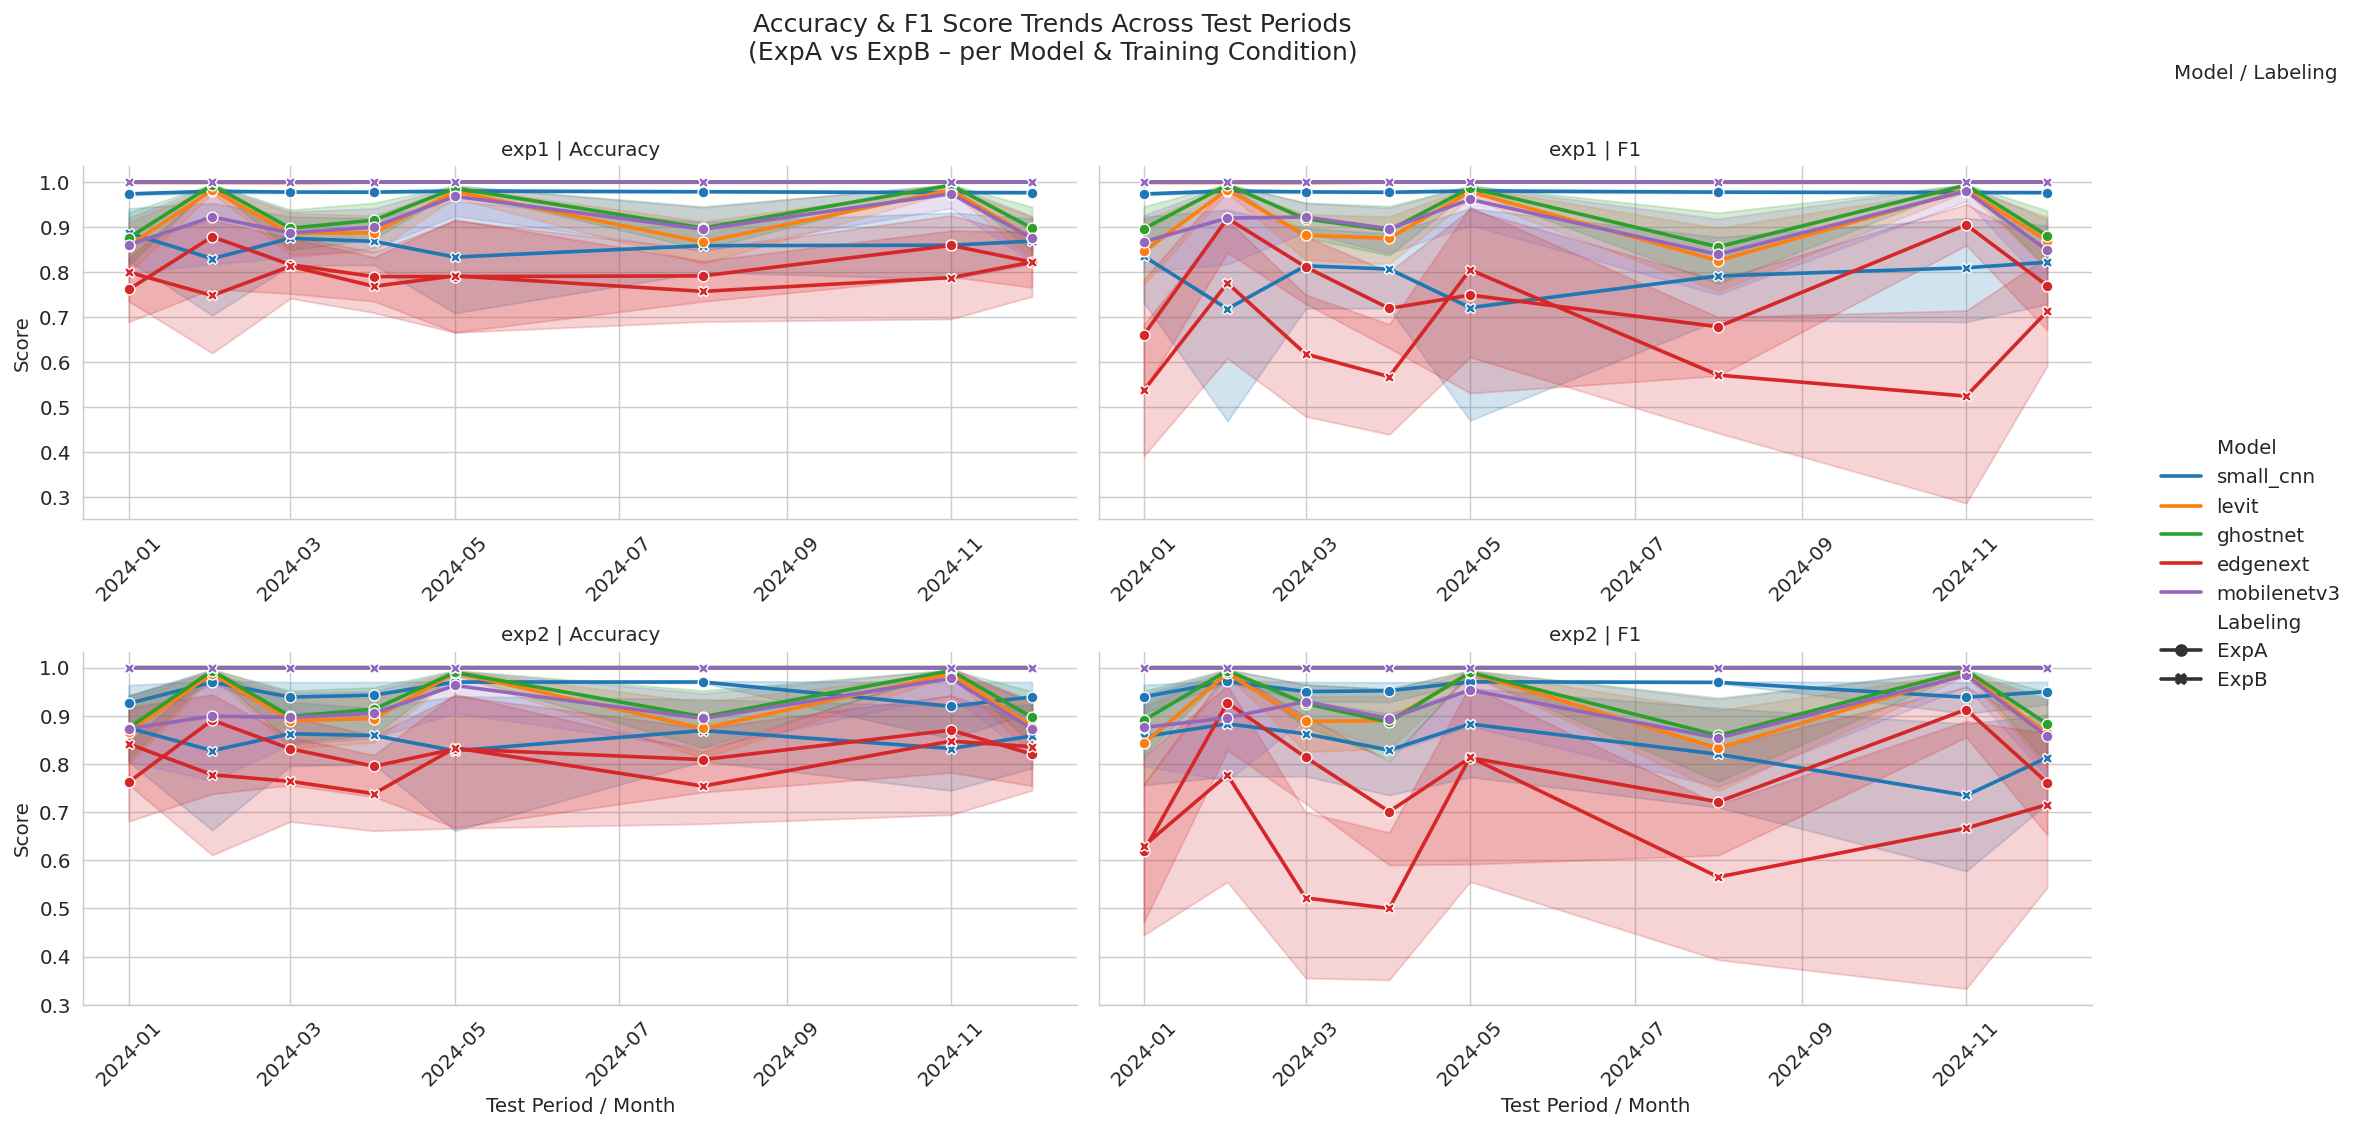

In [21]:
# ────────────────────────────────────────────────
# Cell 3: Line Plot – F1 & Accuracy over Periods/Months
# ────────────────────────────────────────────────
if 'df' in locals() and not df.empty:
    
    # Melt for plotting
    df_long = pd.melt(
        df,
        id_vars=['Labeling', 'Experiment', 'Model', 'Coin', 'Month', 'Month_sort', 'Period'],
        value_vars=METRICS_TO_PLOT,
        var_name='Metric',
        value_name='Score'
    )
    
    # Sort periods (use Month_sort if datetime, else string)
    sort_col = 'Month_sort' if 'Month_sort' in df_long.columns else 'Month'
    df_long = df_long.sort_values(sort_col)
    
    # ── Facet by Metric + Experiment ────────────────────────────────
    g = sns.relplot(
        data=df_long,
        kind='line',
        x=sort_col,
        y='Score',
        hue='Model',
        style='Labeling',
        col='Metric',
        row='Experiment',
        palette='tab10',
        markers=True,
        dashes=False,
        linewidth=2,
        height=4.2,
        aspect=1.6,
        facet_kws={'sharex': False, 'sharey': 'row'}
    )
    
    # Improve titles & labels
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    g.set_axis_labels("Test Period / Month", "Score")
    g.add_legend(title='Model / Labeling', bbox_to_anchor=(1.02, 1), loc='upper left')
    g.fig.suptitle('Accuracy & F1 Score Trends Across Test Periods\n(ExpA vs ExpB – per Model & Training Condition)', y=1.03, fontsize=14)
    
    # Rotate x-ticks if many periods
    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('line_accuracy_f1_by_period_facet_by_metric_and_exp.png', dpi=300, bbox_inches='tight')
    plt.show()

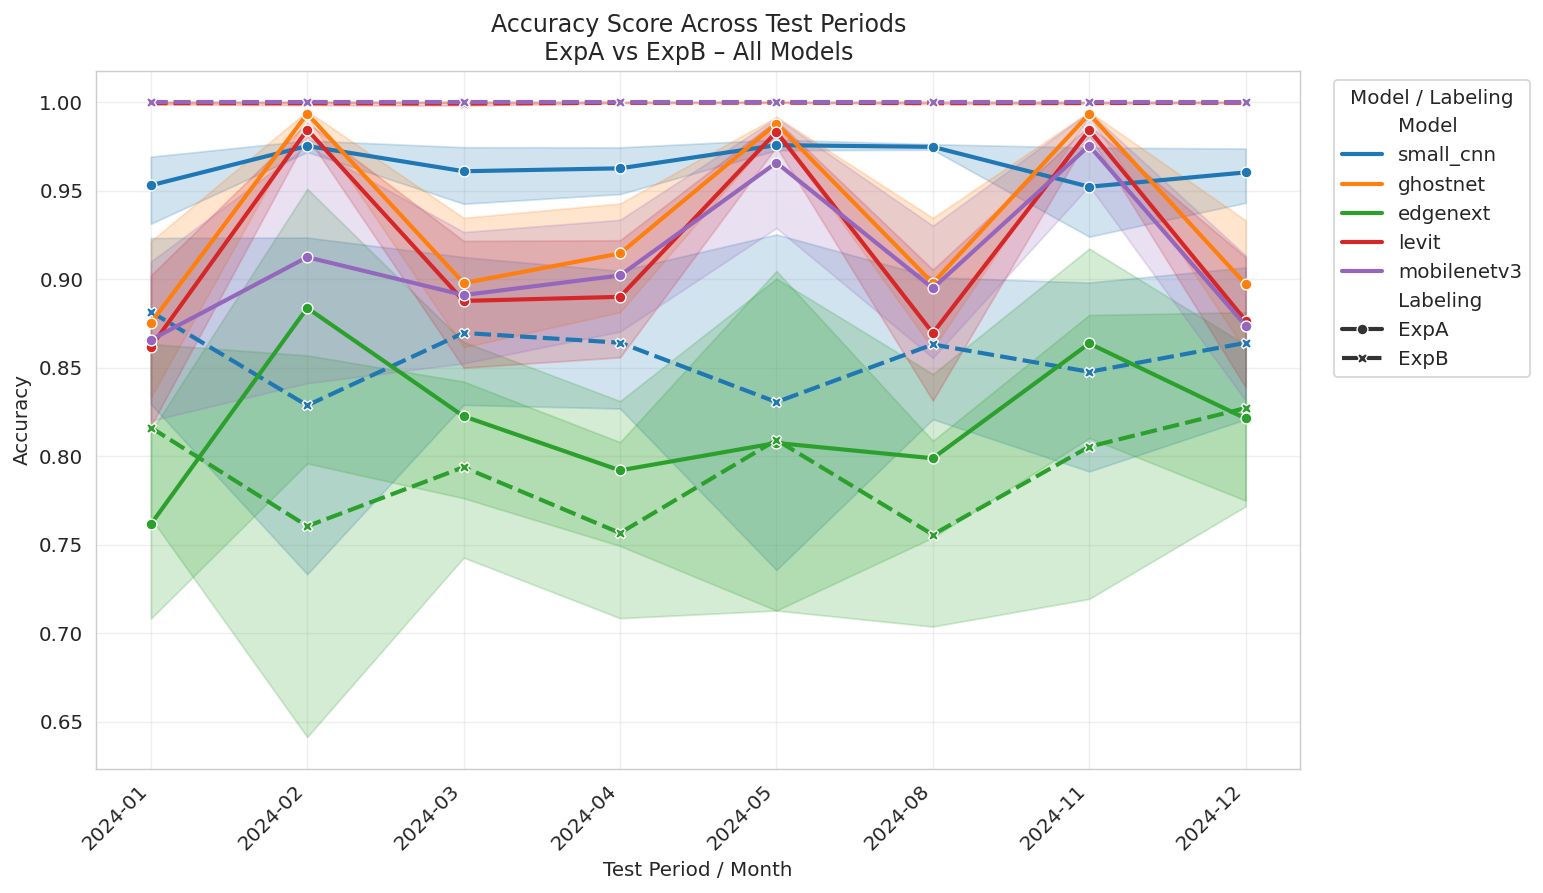

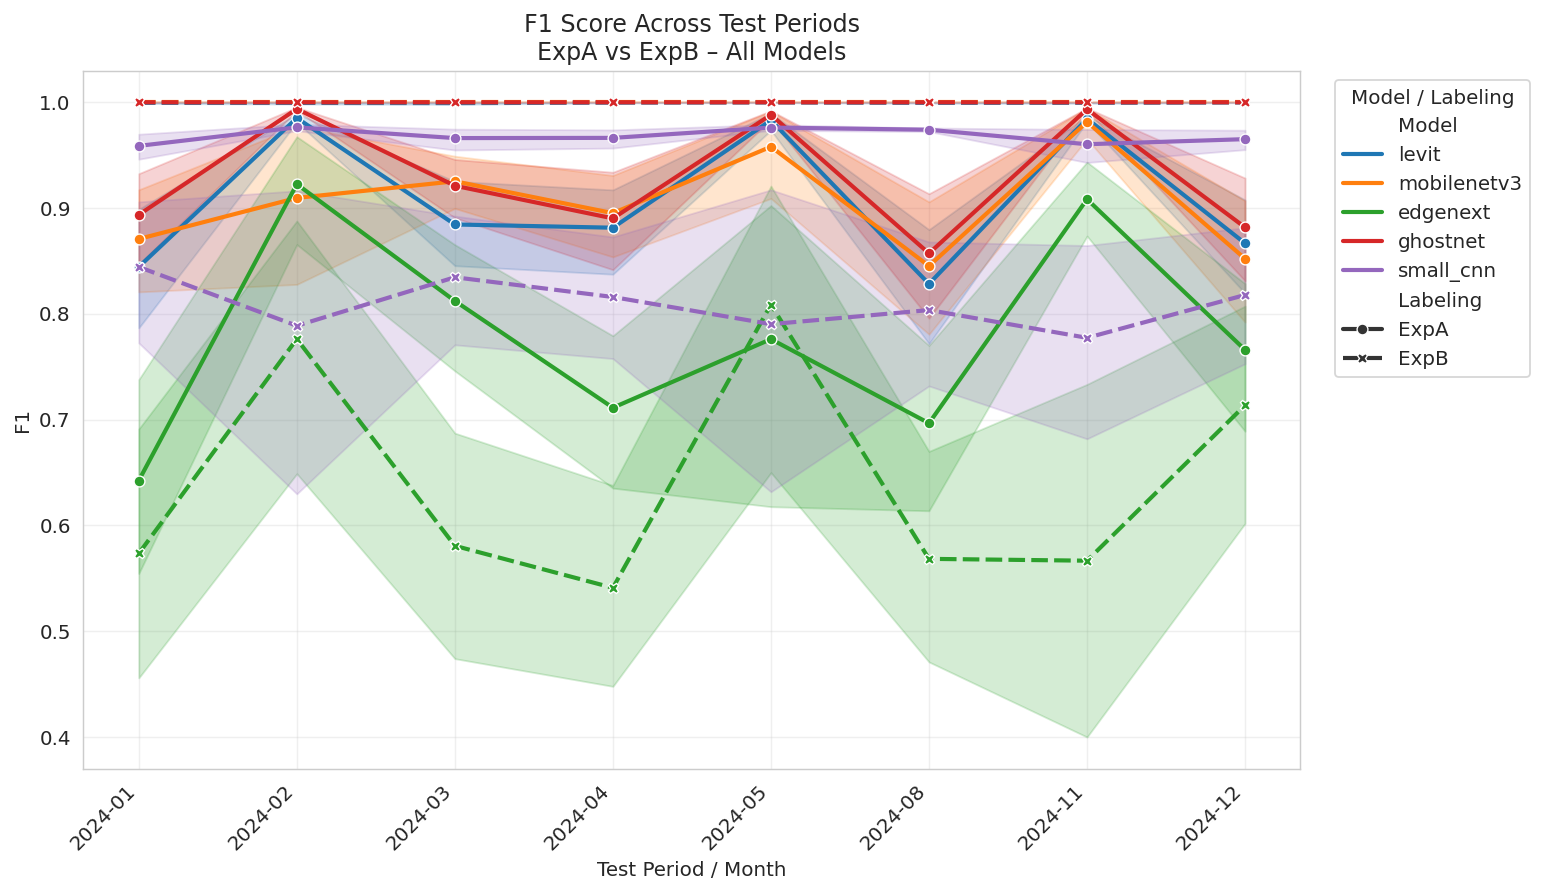

In [22]:
# ────────────────────────────────────────────────
# Cell 4: Alternative – One big plot per metric (less faceting)
# ────────────────────────────────────────────────
if 'df' in locals() and not df.empty:
    
    for metric in METRICS_TO_PLOT:
        plt.figure(figsize=(12, 7))
        
        sns.lineplot(
            data=df_long[df_long['Metric'] == metric],
            x='Month' if 'Month' in df_long else 'Period',
            y='Score',
            hue='Model',
            style='Labeling',
            markers=True,
            linewidth=2.3,
            palette='tab10'
        )
        
        plt.title(f'{metric} Score Across Test Periods\nExpA vs ExpB – All Models')
        plt.xlabel('Test Period / Month')
        plt.ylabel(metric)
        plt.xticks(rotation=45, ha='right')
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Model / Labeling')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'line_{metric.lower()}_by_period_all_in_one.png', dpi=300, bbox_inches='tight')
        plt.show()

# Per Window Size

In [7]:
# ────────────────────────────────────────────────
# Cell 1: Imports & Paths
# ────────────────────────────────────────────────
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 600
plt.rcParams['font.size'] = 11

METRICS = ['F1', 'Accuracy']

BASE_DIRS = {
    'ExpA': '/home/nckh2/qa/delete/ExpA',   # Full-window labeling
    'ExpB': '/home/nckh2/qa/delete/ExpB'    # Last-candle labeling
}

print("Loading test results...\n")

Loading test results...



In [8]:
# ────────────────────────────────────────────────
# Cell 2: Load & Prepare Data
# ────────────────────────────────────────────────
all_data = []

for label, dir_path in BASE_DIRS.items():
    files = glob.glob(os.path.join(dir_path, "*_exp*_results.csv"))
    print(f"→ {label}: {len(files)} files")
    
    for filepath in files:
        try:
            df = pd.read_csv(filepath)
            df.columns = df.columns.str.strip()
            
            # Standardize Experiment
            if 'Experiment' in df.columns:
                df['Experiment'] = df['Experiment'].astype(str).replace({'I': 'Condition I', 'II': 'Condition II'})
                df['Experiment'] = df['Experiment'].str.lower().str.replace(r'^experiment\s*', 'exp', regex=True)
            
            # Filter test rows
            if 'Dataset' in df.columns:
                df = df[df['Dataset'].astype(str).str.lower().str.contains('test', na=False) &
                        ~df['Dataset'].astype(str).str.lower().str.contains('train', na=False)].copy()
            
            if df.empty:
                continue
            
            df['Labeling'] = label
            df['Month_dt'] = pd.to_datetime(df.get('Month', df.get('month_str', pd.NA)), errors='coerce')
            
            # Ensure numeric
            for m in METRICS:
                if m in df.columns:
                    df[m] = pd.to_numeric(df[m], errors='coerce')
            
            all_data.append(df)
            print(f"  → {os.path.basename(filepath)}: {len(df)} test rows")
            
        except Exception as e:
            print(f"  error {os.path.basename(filepath)}: {e}")

if not all_data:
    print("No data loaded.")
else:
    df_all = pd.concat(all_data, ignore_index=True)
    df_all = df_all.sort_values(['Labeling', 'Experiment', 'Coin', 'Model', 'Month_dt', 'Window_Size'])
    
    print(f"\nTotal test rows: {len(df_all)}")
    print("Unique models:", df_all['Model'].unique())
    print("Unique periods:", df_all['Period'].unique() if 'Period' in df_all else "No Period column")

→ ExpA: 12 files
  → ADAUSDT_exp1_results.csv: 300 test rows
  → BTCUSDT_exp2_results.csv: 225 test rows
  → BNBUSDT_exp2_results.csv: 225 test rows
  → ADAUSDT_exp2_results.csv: 225 test rows
  → XRPUSDT_exp2_results.csv: 225 test rows
  → BNBUSDT_exp1_results.csv: 300 test rows
  → BTCUSDT_exp1_results.csv: 300 test rows
  → XRPUSDT_exp1_results.csv: 300 test rows
  → ETHUSDT_exp2_results.csv: 225 test rows
  → ETHUSDT_exp1_results.csv: 300 test rows
  → DOGEUSDT_exp1_results.csv: 300 test rows
  → DOGEUSDT_exp2_results.csv: 225 test rows
→ ExpB: 12 files
  → ADAUSDT_exp1_results.csv: 276 test rows
  → BTCUSDT_exp2_results.csv: 225 test rows
  → BNBUSDT_exp2_results.csv: 225 test rows
  → ADAUSDT_exp2_results.csv: 195 test rows
  → XRPUSDT_exp2_results.csv: 210 test rows
  → BNBUSDT_exp1_results.csv: 300 test rows
  → BTCUSDT_exp1_results.csv: 300 test rows
  → XRPUSDT_exp1_results.csv: 291 test rows
  → ETHUSDT_exp2_results.csv: 225 test rows
  → ETHUSDT_exp1_results.csv: 300 test r

/tmp/ipykernel_1573729/3570811041.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Month_dt'] = pd.to_datetime(df.get('Month', df.get('month_str', pd.NA)), errors='coerce')
/tmp/ipykernel_1573729/3570811041.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Month_dt'] = pd.to_datetime(df.get('Month', df.get('month_str', pd.NA)), errors='coerce')
/tmp/ipykernel_1573729/3570811041.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Month_dt'] = pd.to_datetime(df.get('Month', df.get('month_str', pd.NA)), errors='coerce')
/tmp/ipykernel_1573729/3570811041.py:

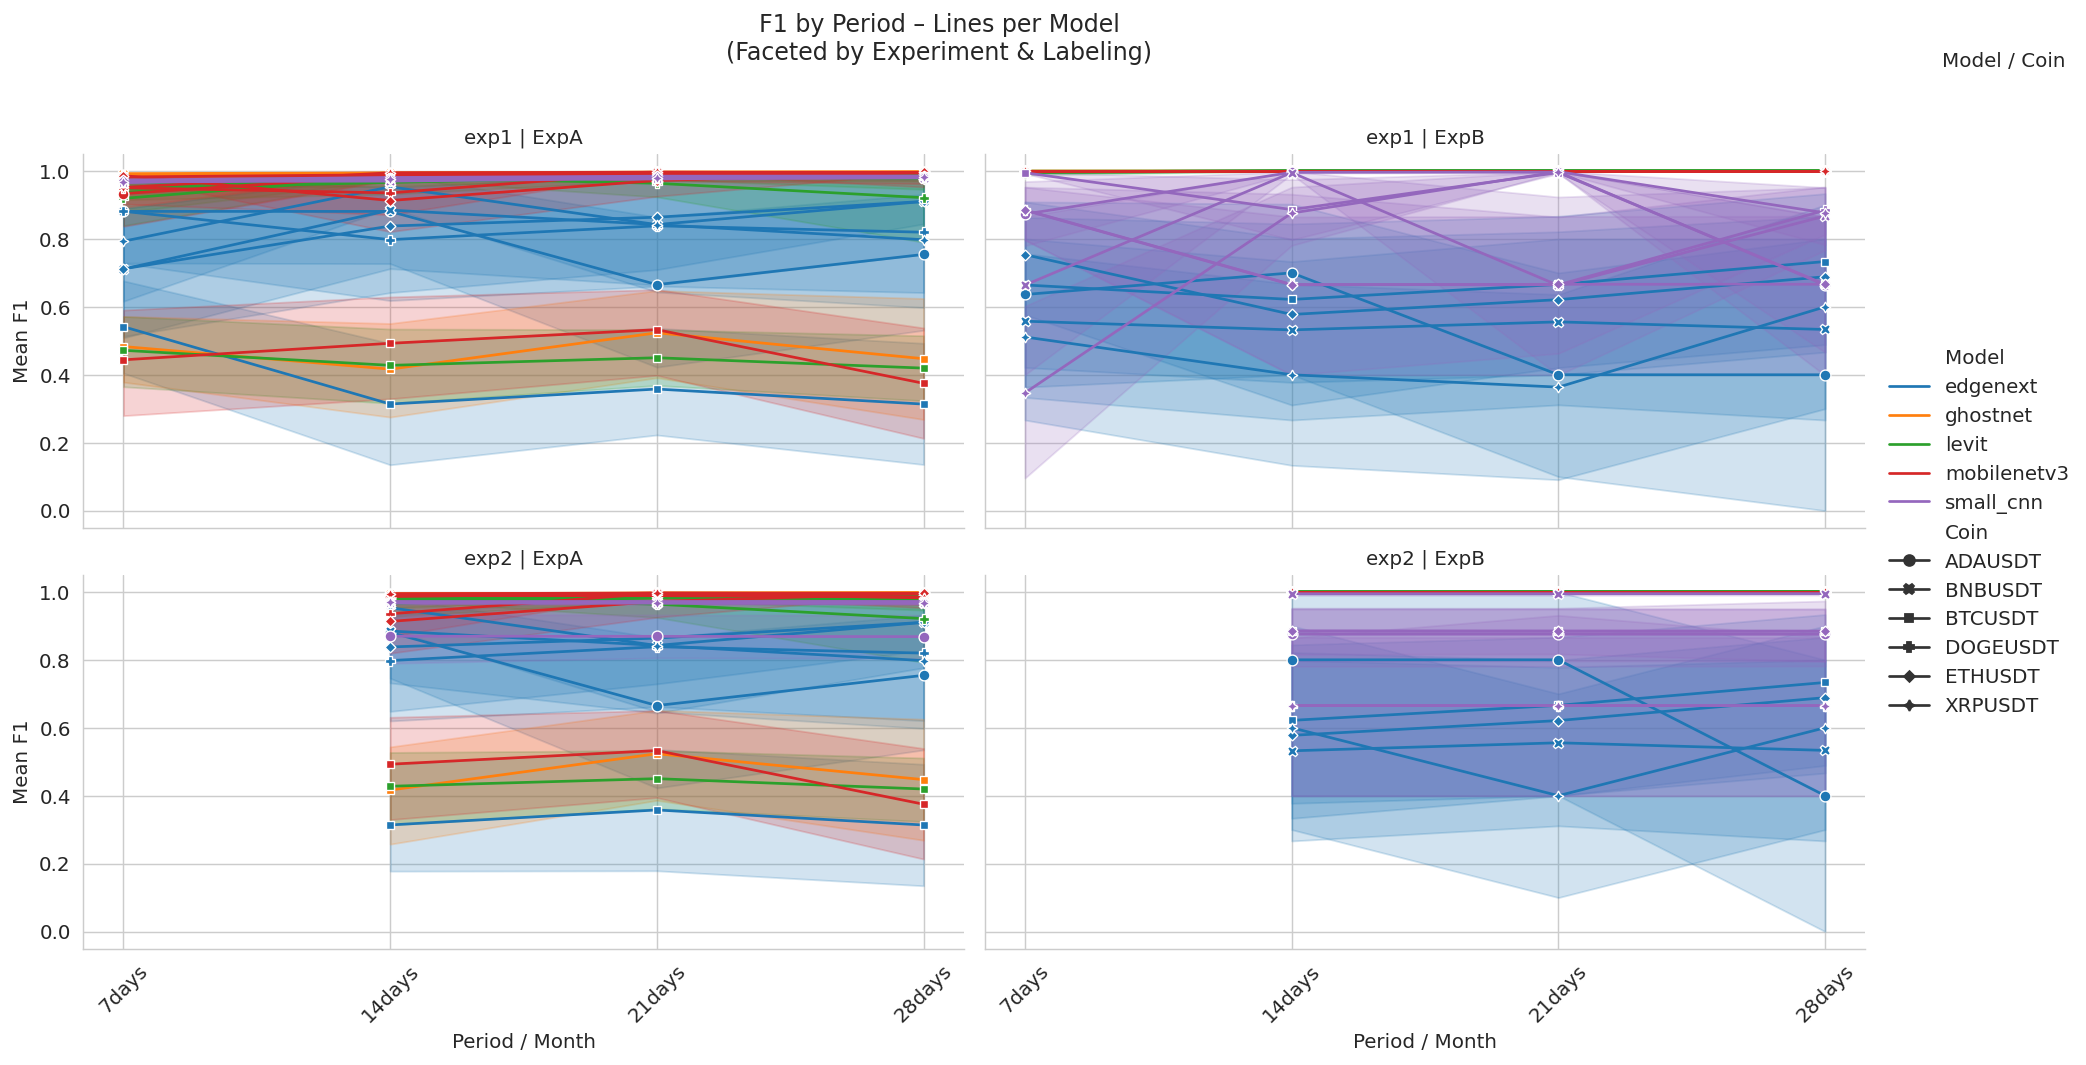

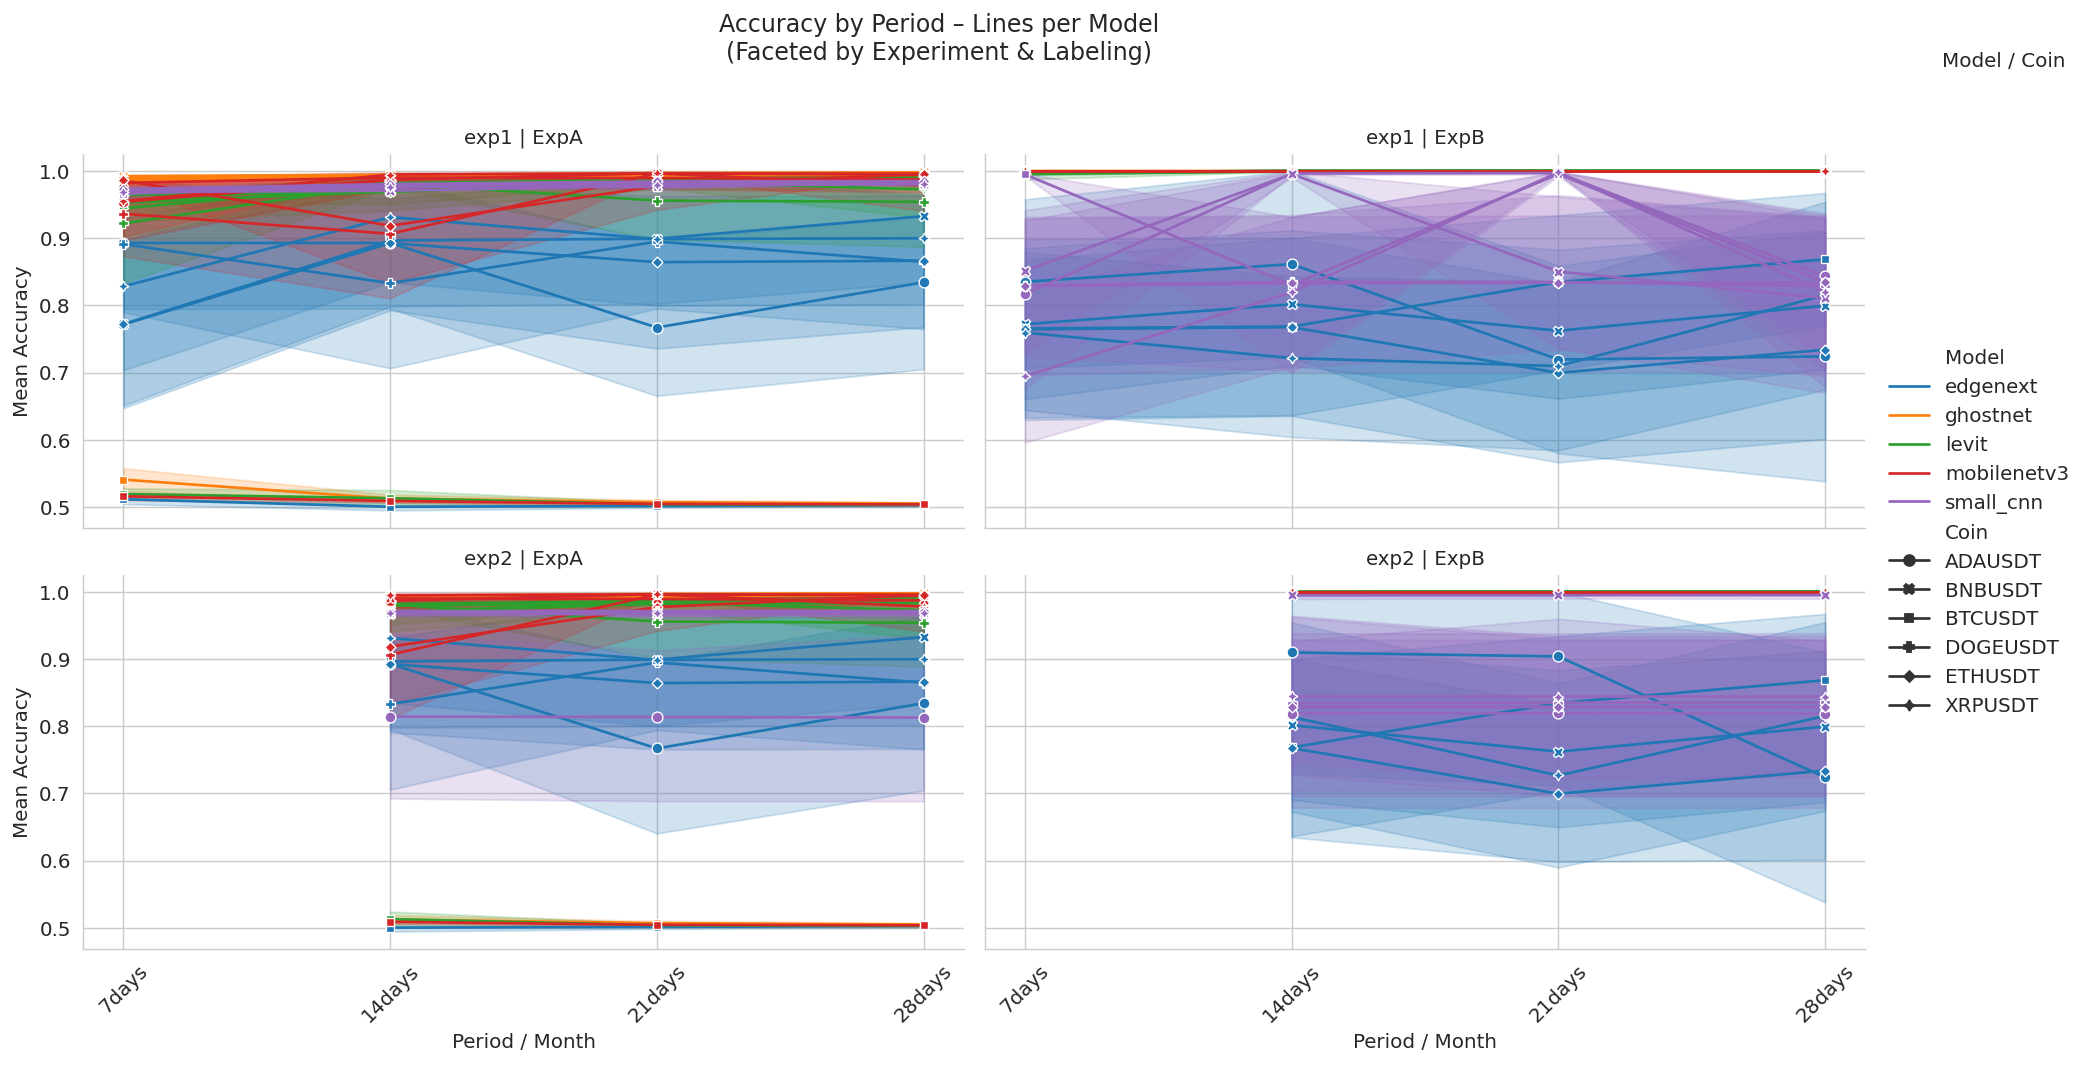

In [26]:
# ────────────────────────────────────────────────
# Cell 3: Line Plot – F1 & Accuracy by Period (facet by Labeling & Experiment)
# ────────────────────────────────────────────────
if 'df_all' in locals() and not df_all.empty:
    for metric in METRICS:
        # Melt for plotting
        df_melt_period = df_all.melt(
            id_vars=['Labeling', 'Experiment', 'Model', 'Coin', 'Period', 'Month_dt', 'Window_Size'],
            value_vars=[metric],
            var_name='Metric',
            value_name='Score'
        )
        
        # Sort periods if categorical (e.g., 7days, 14days...)
        if 'Period' in df_melt_period:
            period_order = sorted(df_melt_period['Period'].unique(), key=lambda x: int(''.join(filter(str.isdigit, str(x)))))
            df_melt_period['Period'] = pd.Categorical(df_melt_period['Period'], categories=period_order, ordered=True)
        
        g = sns.relplot(
            data=df_melt_period,
            kind='line',
            x='Period' if 'Period' in df_melt_period and df_melt_period['Period'].nunique() > 1 else 'Month_dt',
            y='Score',
            hue='Model',
            style='Coin',  # optional: different lines per coin
            palette='tab10',
            markers=True,
            dashes=False,
            row='Experiment',
            col='Labeling',
            facet_kws={'sharey': True, 'sharex': True},
            height=4, aspect=1.5
        )
        
        g.set_titles(row_template="{row_name}", col_template="{col_name}")
        g.set_axis_labels("Period / Month", f"Mean {metric}")
        g.fig.suptitle(f'{metric} by Period – Lines per Model\n(Faceted by Experiment & Labeling)', y=1.02)
        g.add_legend(title='Model / Coin', bbox_to_anchor=(1.02, 1), loc='upper left')
        
        # Rotate x labels if months
        for ax in g.axes.flat:
            ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(f'line_{metric.lower()}_by_period.png', dpi=300, bbox_inches='tight')
        plt.show()

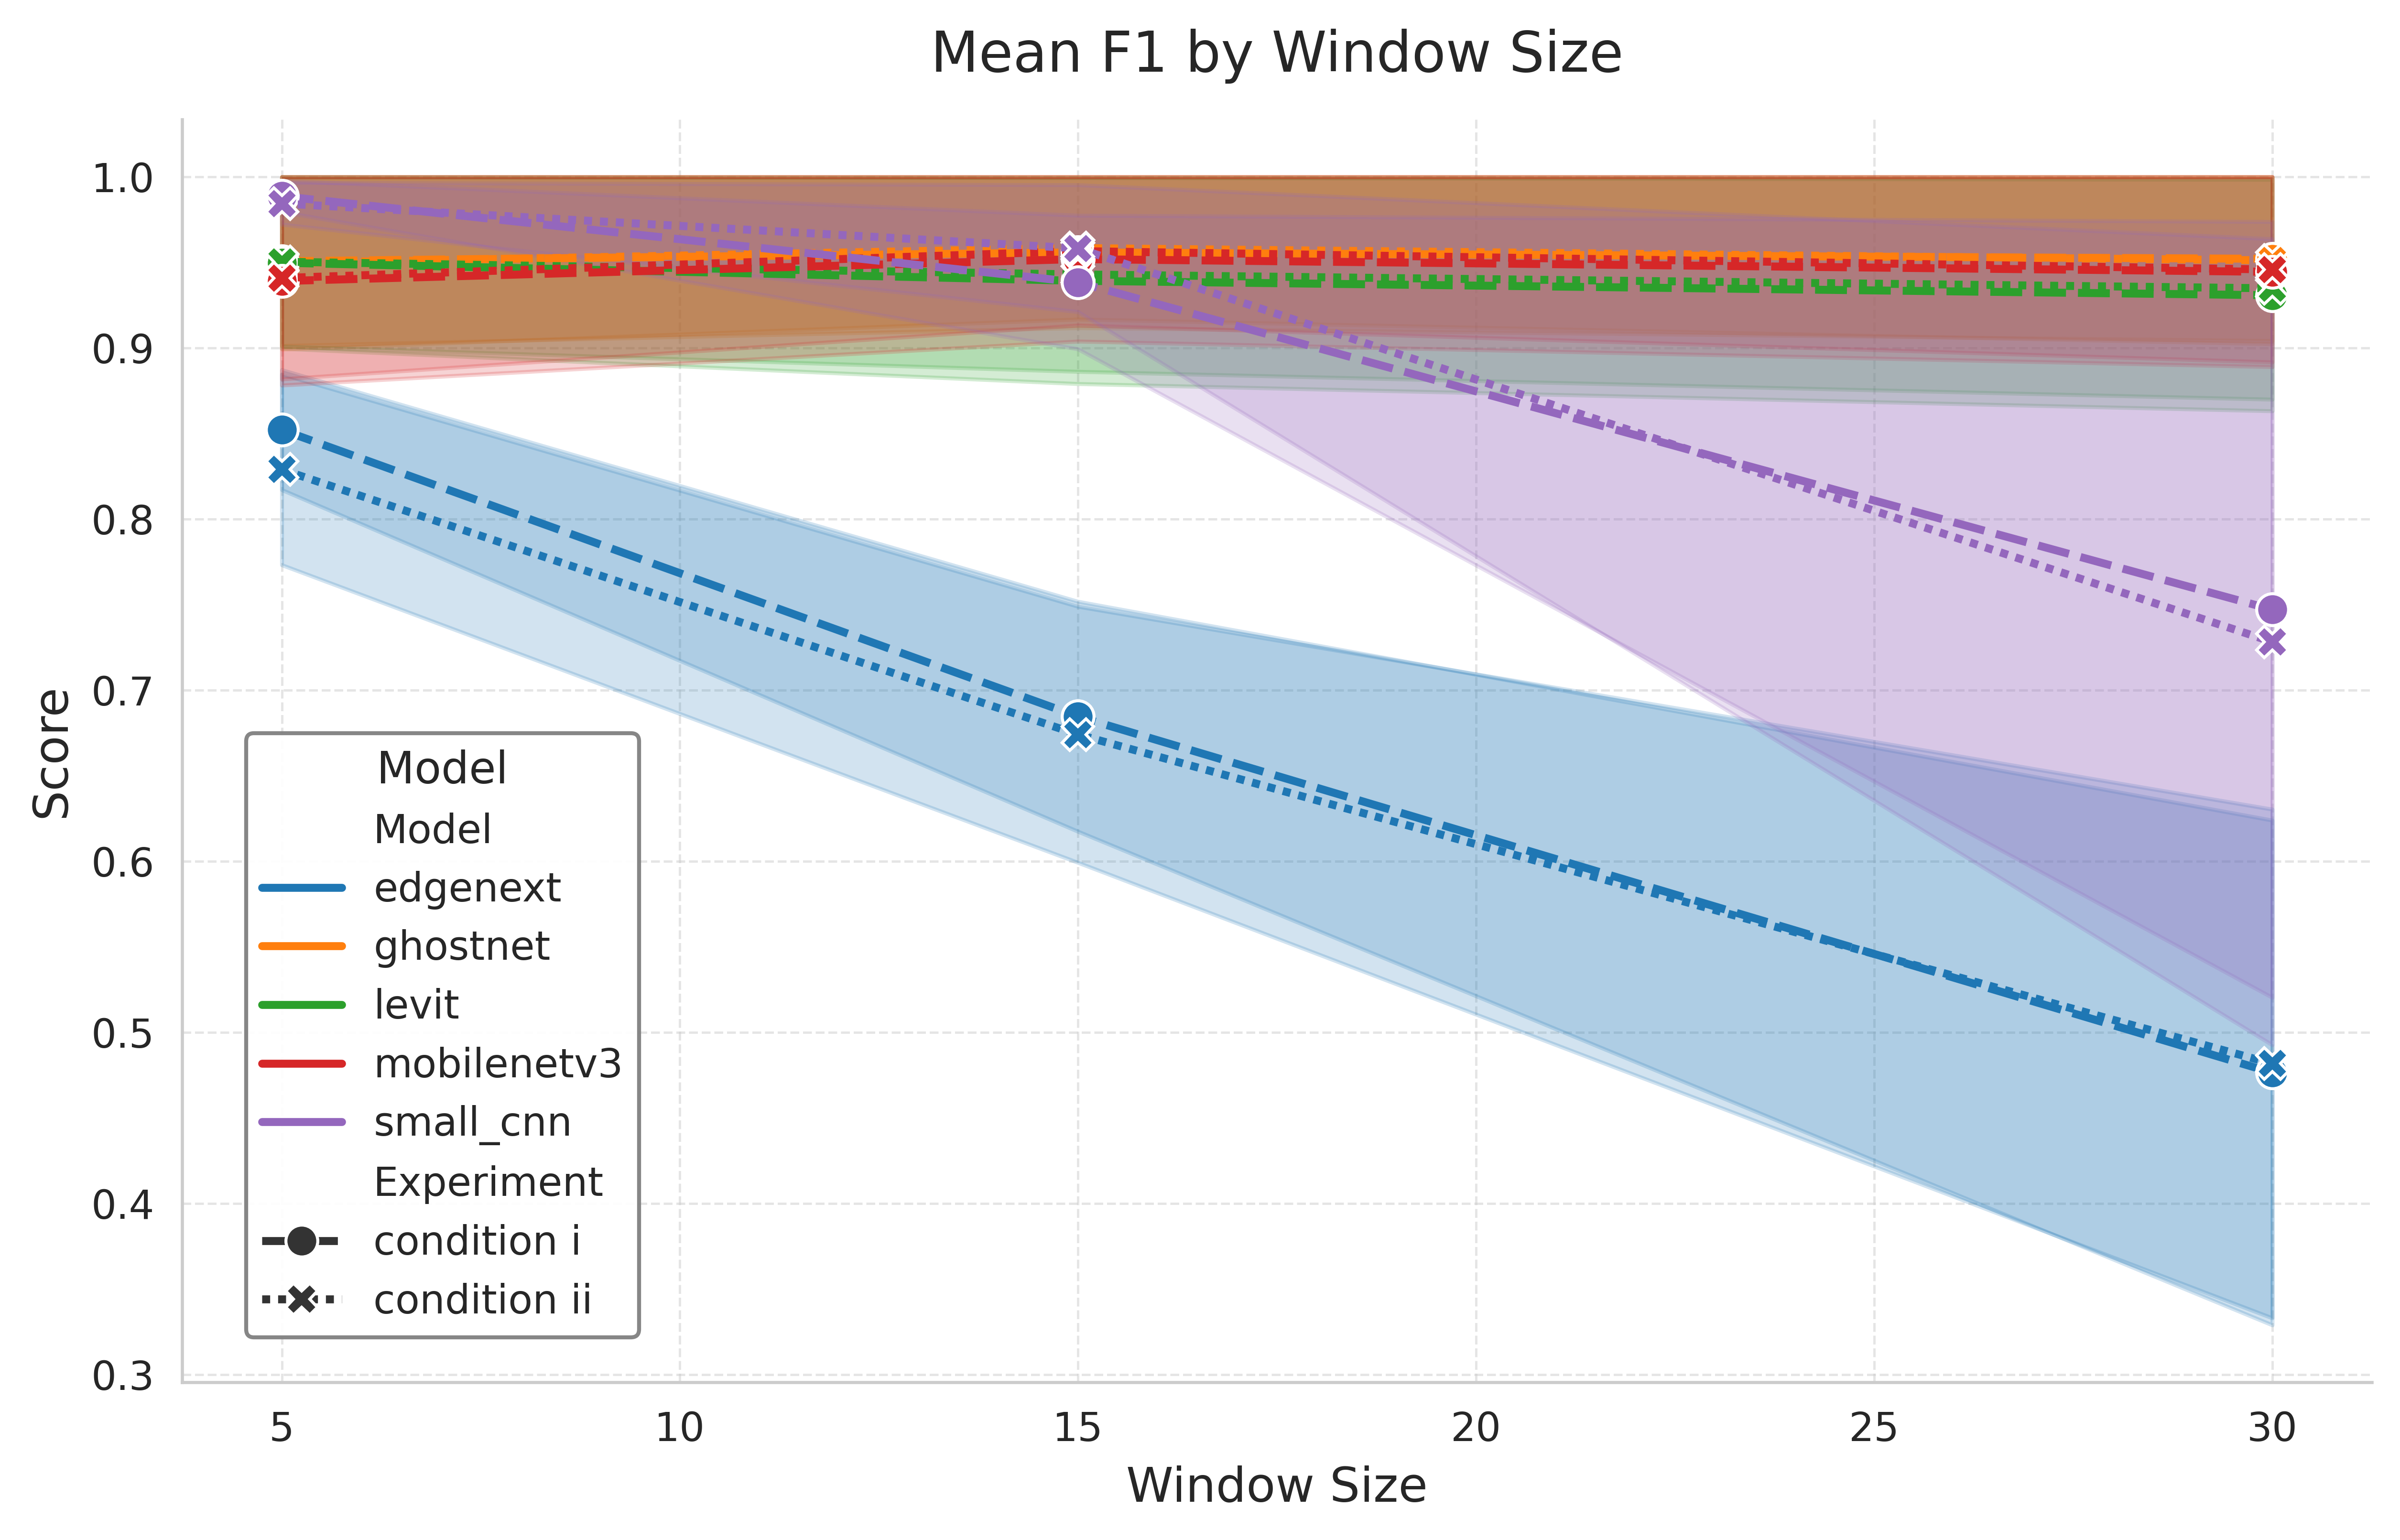

Saved: line_f1_by_window_size_publication.png


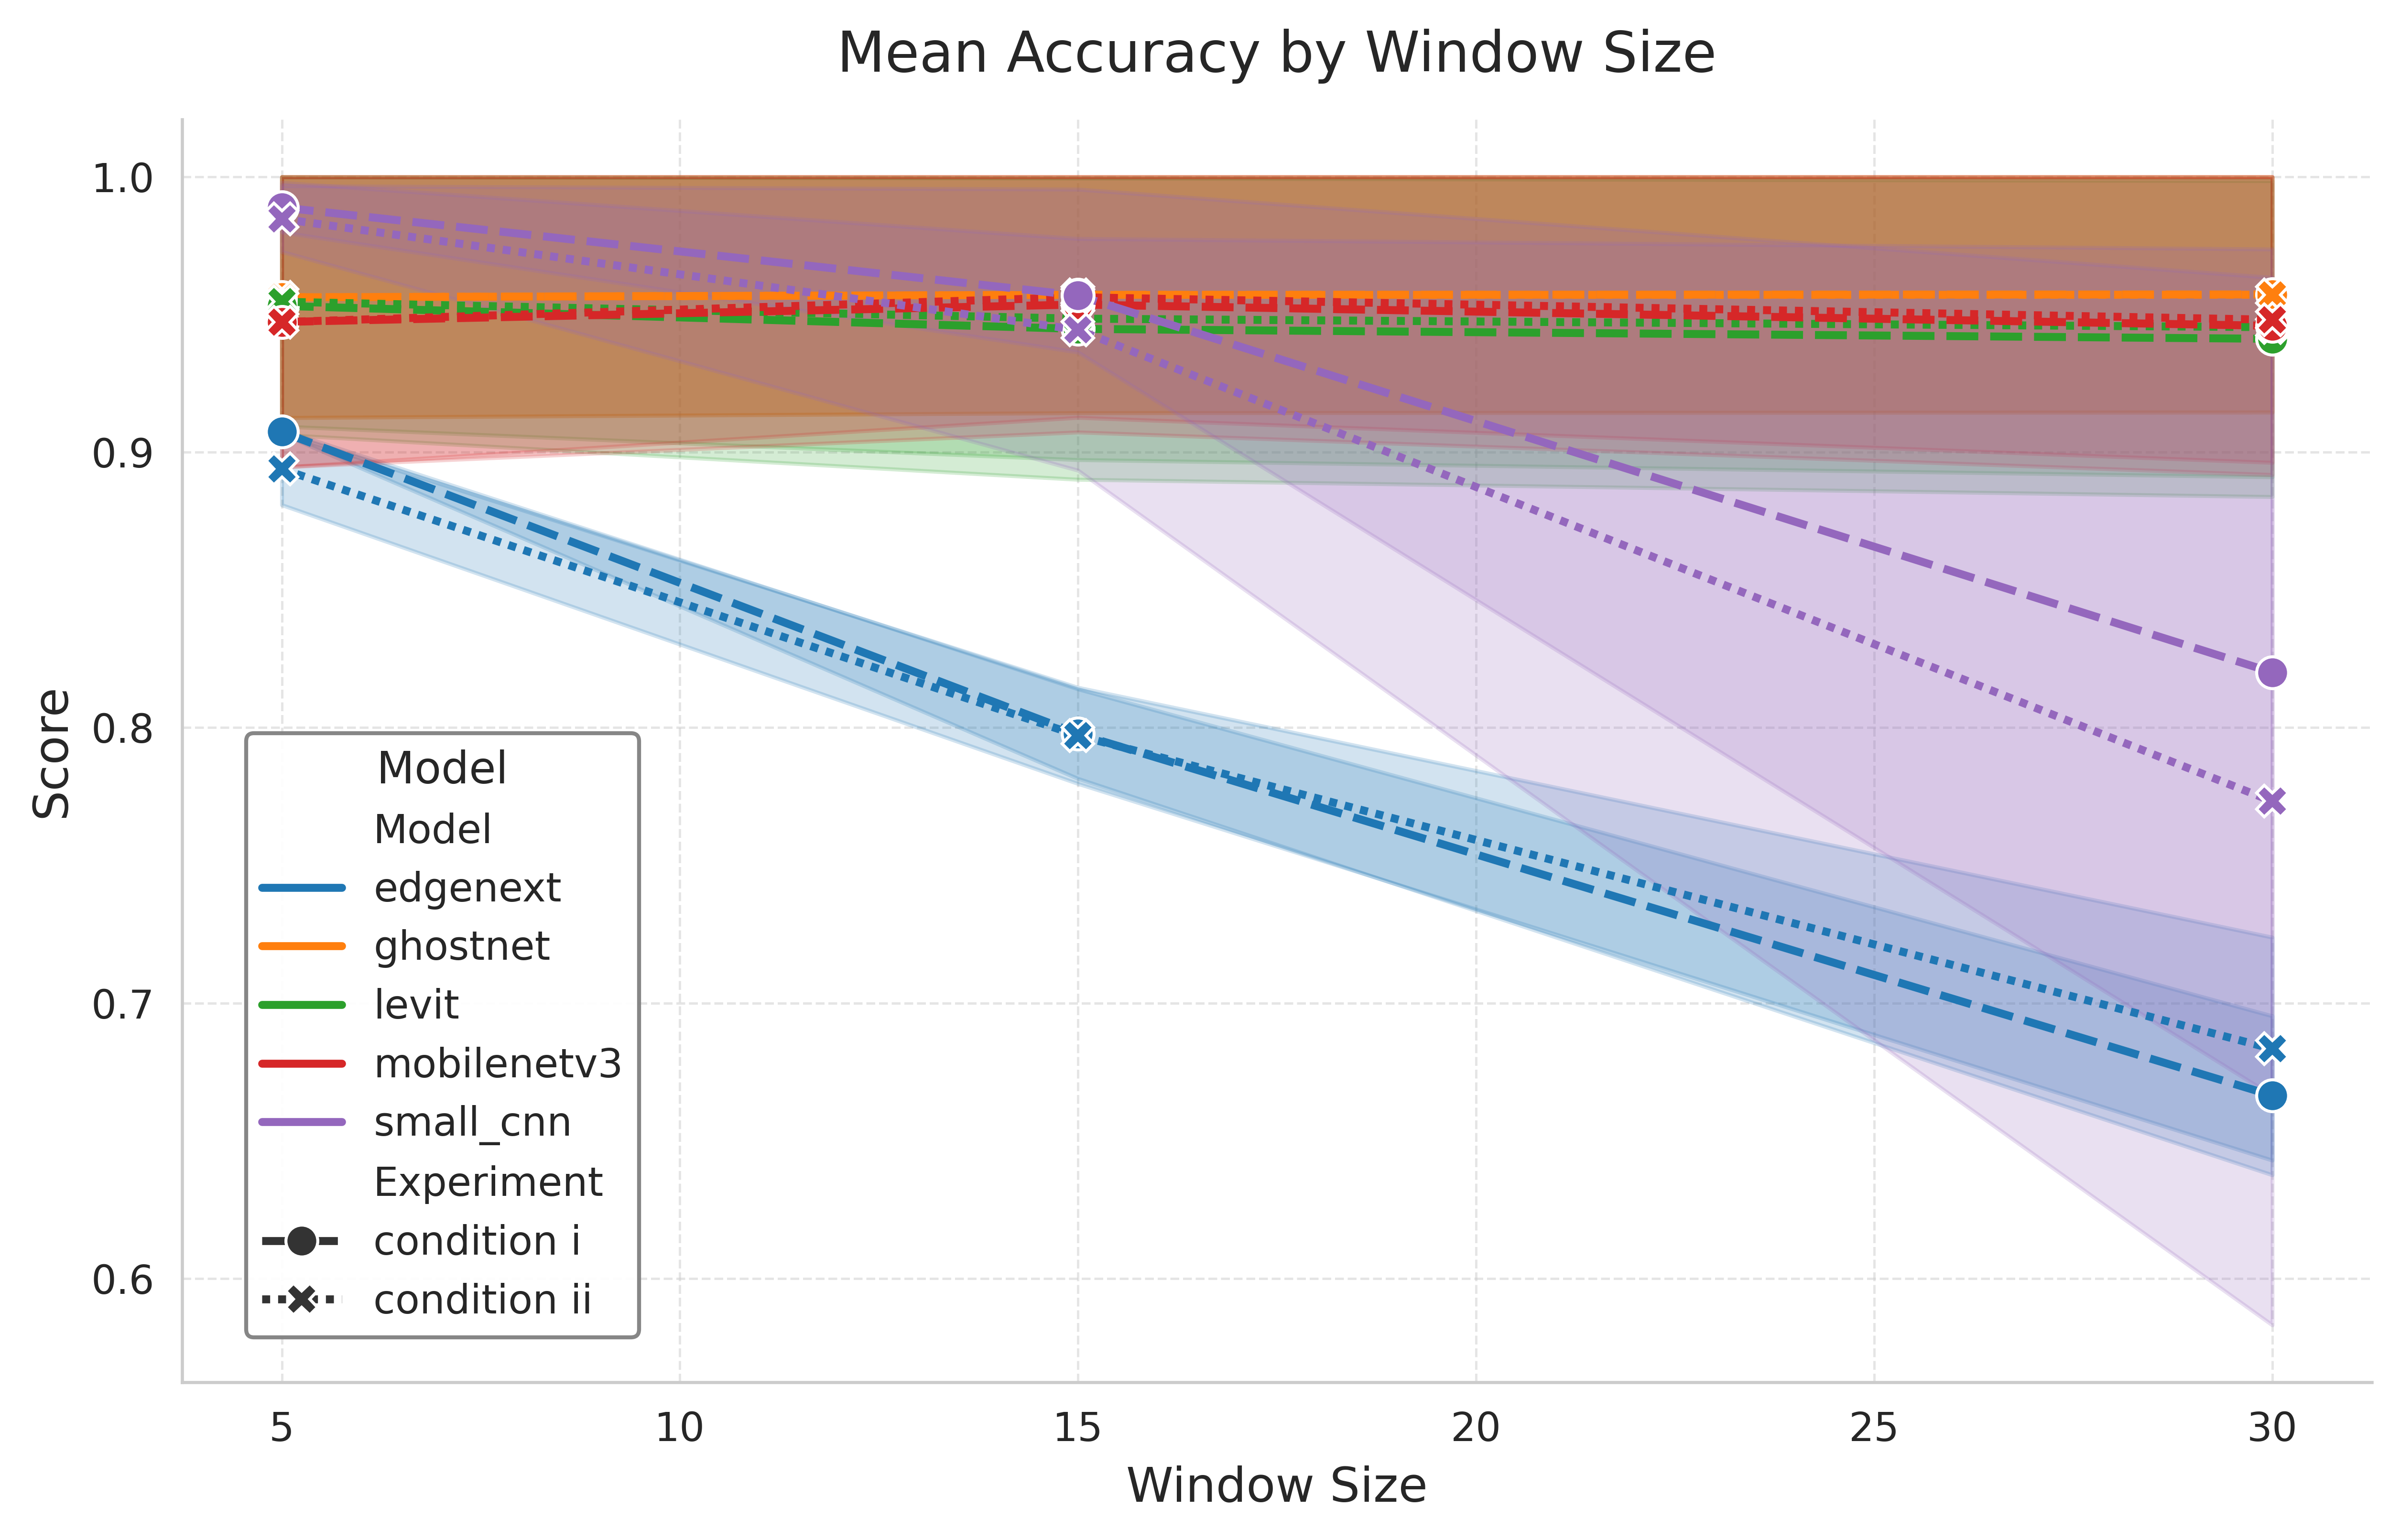

Saved: line_accuracy_by_window_size_publication.png


In [ ]:
# ────────────────────────────────────────────────
# Cell: Plot F1 and Accuracy by Window Size – publication style
# ────────────────────────────────────────────────
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ─── Assume df_all already exists from previous loading cells ───
# If not, you need to run the loading code first

if 'df_all' not in locals() or df_all.empty:
    print("df_all not found or empty. Run the data loading cells first.")
else:
    # Prepare aggregated data (average across periods/months if multiple)
    metrics = ['F1', 'Accuracy']

    for metric in metrics:
        # Melt → average per window / model / labeling / experiment
        df_plot = df_all.melt(
            id_vars=['Labeling', 'Experiment', 'Model', 'Window_Size'],
            value_vars=[metric],
            var_name='Metric',
            value_name='Score'
        )

        df_agg = df_plot.groupby(
            ['Labeling', 'Experiment', 'Model', 'Window_Size']
        )['Score'].mean().reset_index()

        # Figure settings for double-column paper
        fig, ax = plt.subplots(figsize=(8.5, 5.5), dpi=600)

        sns.lineplot(
            data=df_agg,
            x='Window_Size',
            y='Score',
            hue='Model',
            style='Experiment',
            markers=True,
            dashes=[(4, 1.5), (1, 1)],          # different dash styles for exp1/exp2
            palette='tab10',
            linewidth=2.0,
            markersize=8,
            ax=ax
        )

        # Titles & labels – readable sizes
        ax.set_title(f'Mean {metric} by Window Size', 
                     fontsize=14, pad=12)
        ax.set_xlabel('Window Size', fontsize=12)
        ax.set_ylabel(f'', fontsize=12)

        # Ticks
        ax.tick_params(axis='both', labelsize=10)

        # Legend → bottom left, inside plot, smaller font
        ax.legend(
            title='Model / Experiment',
            loc='lower left',
            bbox_to_anchor=(0.02, 0.02),
            fontsize=10,
            title_fontsize=11,
            frameon=True,
            framealpha=0.95,
            edgecolor='gray'
        )

        # Minor grid for better readability
        ax.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.5)

        # Remove top/right spines for cleaner look
        sns.despine(ax=ax, top=True, right=True)

        plt.tight_layout()
        plt.savefig(f'line_{metric.lower()}_by_window_size_publication.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Saved: line_{metric.lower()}_by_window_size_publication.png")

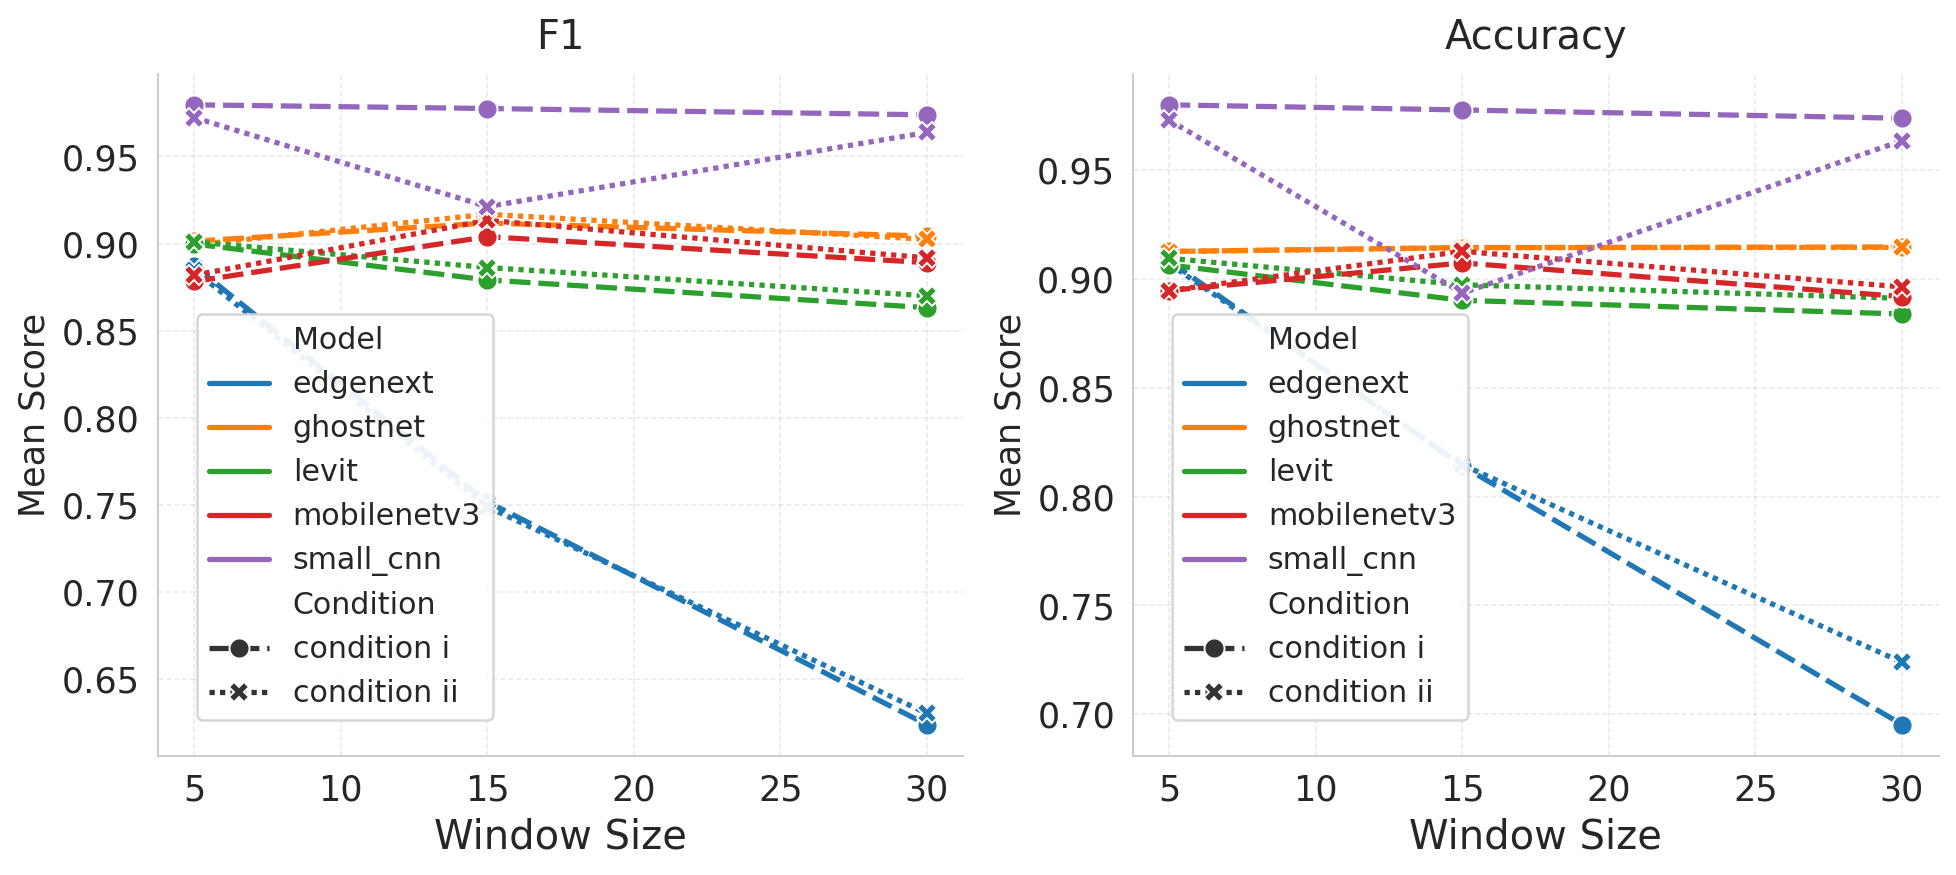

Saved: line_performance_by_window_ExpA.png


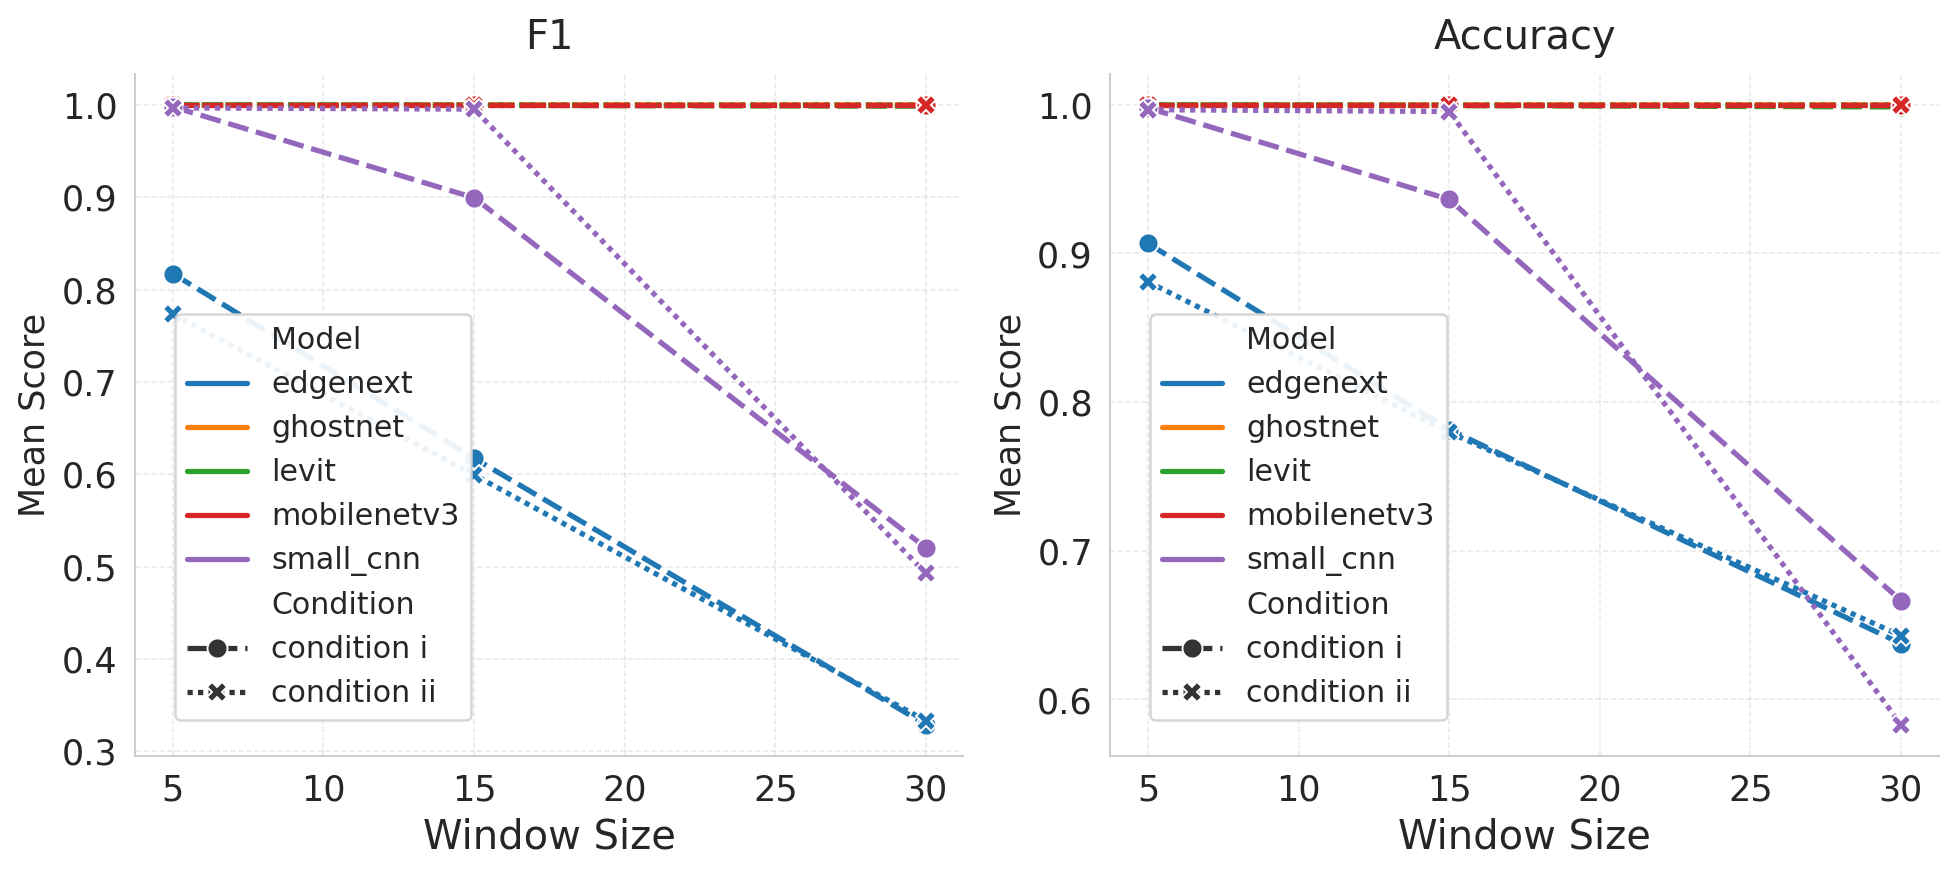

Saved: line_performance_by_window_ExpB.png


In [12]:
# ────────────────────────────────────────────────
# Cell: Plot F1 and Accuracy by Window Size – Separate for ExpA and ExpB
# ────────────────────────────────────────────────
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df_all already exists from previous loading code
# If not → run the data loading cells first

if 'df_all' not in locals() or df_all.empty:
    print("df_all not found or empty. Please run the data loading code first.")
else:
    # Rename exp1 → Condition I, exp2 → Condition II
    df_plot = df_all.copy()
    df_plot['Condition'] = df_plot['Experiment'].replace({
        'exp1': 'Condition I',
        'exp2': 'Condition II'
    })

    # Only keep rows with valid Window_Size
    df_plot = df_plot[df_plot['Window_Size'].notna()]

    for labeling in ['ExpA', 'ExpB']:
        df_subset = df_plot[df_plot['Labeling'] == labeling]
        
        if df_subset.empty:
            print(f"No data for {labeling}")
            continue

        # Melt for plotting
        df_melt = df_subset.melt(
            id_vars=['Condition', 'Model', 'Window_Size'],
            value_vars=['F1', 'Accuracy'],
            var_name='Metric',
            value_name='Score'
        )

        # Average per Window_Size / Model / Condition / Metric
        df_agg = df_melt.groupby(
            ['Condition', 'Model', 'Window_Size', 'Metric']
        )['Score'].mean().reset_index()

        # Create figure with two subplots side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(11, 5.2), dpi=180, sharey=False)
        # fig.suptitle(f'Mean Performance by Window Size – {labeling}', 
        #              fontsize=14, y=1.00)

        for idx, metric in enumerate(['F1', 'Accuracy']):
            ax = axes[idx]
            df_metric = df_agg[df_agg['Metric'] == metric]

            sns.lineplot(
                data=df_metric,
                x='Window_Size',
                y='Score',
                hue='Model',
                style='Condition',
                markers=True,
                dashes=[(4, 1.5), (1, 1)],          # solid vs dashed for I/II
                palette='tab10',
                linewidth=2.1,
                markersize=8,
                ax=ax
            )

            ax.set_title(f'{metric}', fontsize=16, pad=10)
            ax.set_xlabel('Window Size', fontsize=16)
            ax.set_ylabel(f'Mean Score', fontsize=14)
            ax.tick_params(axis='both', labelsize=14)

            # Legend inside plot – bottom left
            ax.legend(
                # title='Model / Condition',
                loc='lower left',
                bbox_to_anchor=(0.03, 0.03),
                fontsize=12,
                title_fontsize=12.5,
                frameon=True,
                framealpha=0.92,
                edgecolor='lightgray'
            )

            # Light grid + clean spines
            ax.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.45)
            sns.despine(ax=ax, top=True, right=True)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f'{labeling}.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()

        print(f"Saved: line_performance_by_window_{labeling}.png")

In [20]:
# ──────────────────────────────────────────────────────────────
# Statistical Comparison: Condition I vs Condition II (ExpA & ExpB)
# ──────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# ──────────────────────────────────────────────────────────────
# 1. Load all results
# ──────────────────────────────────────────────────────────────
base_path = Path("/home/nckh2/qa/delete")

files = list(base_path.rglob("*_exp*_results.csv"))
print(f"Found {len(files)} result files")

dfs = []

for filepath in files:
    df = pd.read_csv(filepath)
    
    # Determine labeling and condition
    folder = str(filepath.parent)
    labeling = "Experiment A" if "ExpA" in folder else "Experiment B"
    condition = "Condition I" if "_exp1_" in filepath.name.lower() else "Condition II"
    
    df['Labeling'] = labeling
    df['Condition'] = condition
    
    # Coin is already in CSV → we just clean it
    if 'Coin' in df.columns:
        df['Coin'] = df['Coin'].astype(str).str.strip().str.upper()
    else:
        # fallback (should not trigger based on your diagnostic)
        coin_from_name = filepath.stem.split('_')[0].upper()
        df['Coin'] = coin_from_name
        print(f"Warning: No 'Coin' column in {filepath.name} → using filename")
    
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Normalize key columns for robust merging
key_columns = ['Coin', 'Model', 'Window_Size', 'Period', 'Month', 'Dataset']
for col in key_columns:
    if col in df_all.columns:
        df_all[col] = df_all[col].astype(str).str.strip().str.upper()

# Ensure numeric columns
metrics = ['Accuracy', 'F1', 'Recall', 'AUROC', 'AUPRC']
for col in metrics + ['Window_Size']:
    if col in df_all.columns:
        df_all[col] = pd.to_numeric(df_all[col], errors='coerce')

print(f"\nLoaded {len(df_all)} rows")
print("Unique coins:", sorted(df_all['Coin'].dropna().unique()))
print("Unique models:", sorted(df_all['Model'].dropna().unique()))
print("Unique windows:", sorted(df_all['Window_Size'].dropna().unique().astype(int)))
print("Columns:", df_all.columns.tolist())

# ──────────────────────────────────────────────────────────────
def get_paired_deltas(df_labeling):
    if df_labeling.empty:
        print("No data for this labeling")
        return pd.DataFrame()
    
    label = df_labeling['Labeling'].iloc[0]
    print(f"\nProcessing {label}")
    
    df_i  = df_labeling[df_labeling['Condition'] == 'Condition I'].copy()
    df_ii = df_labeling[df_labeling['Condition'] == 'Condition II'].copy()
    
    print(f"  Rows Cond I: {len(df_i):4d} | Cond II: {len(df_ii):4d}")
    
    pair_keys = ['Coin', 'Model', 'Window_Size', 'Period', 'Month', 'Dataset']
    
    # Debug check
    missing = [k for k in pair_keys if k not in df_i.columns or k not in df_ii.columns]
    if missing:
        print("  ERROR - Missing keys in subsets:", missing)
        print("  Columns in df_i:", df_i.columns.tolist()[:15])   # truncated
        return pd.DataFrame()
    
    print("  Pairing on:", pair_keys)
    
    # ── FIXED MERGE ──
    left_keys  = [k + '_I'  for k in pair_keys]
    right_keys = [k + '_II' for k in pair_keys]
    
    df_left  = df_i[pair_keys + metrics].add_suffix('_I')
    df_right = df_ii[pair_keys + metrics].add_suffix('_II')
    
    df_paired = pd.merge(
        df_left,
        df_right,
        left_on  = left_keys,
        right_on = right_keys,
        how      = 'inner'
    )
    
    print(f"  Successfully paired rows: {len(df_paired)}")
    
    if df_paired.empty:
        print("  → No matching pairs. Possible reasons:")
        print("    - Different values in Period/Month/Dataset between Cond I and II")
        print("    - Extra spaces, case differences, or formatting issues")
        # Quick peek at mismatched keys
        print("\n  Example keys from Cond I:")
        print(df_i[pair_keys].drop_duplicates().head(3))
        print("\n  Example keys from Cond II:")
        print(df_ii[pair_keys].drop_duplicates().head(3))
    
    # Compute deltas
    for m in metrics:
        df_paired[f'{m}_delta'] = df_paired[f'{m}_II'] - df_paired[f'{m}_I']
        df_paired[f'{m}_pct']   = df_paired[f'{m}_delta'] / df_paired[f'{m}_I'].replace(0, np.nan) * 100
    
    return df_paired

# ──────────────────────────────────────────────────────────────
# 3. Run pairing
# ──────────────────────────────────────────────────────────────
dfA = df_all[df_all['Labeling'] == 'Experiment A'].copy()
dfB = df_all[df_all['Labeling'] == 'Experiment B'].copy()

paired_A = get_paired_deltas(dfA)
paired_B = get_paired_deltas(dfB)

# ──────────────────────────────────────────────────────────────
# 4. Statistics per model + window
# ──────────────────────────────────────────────────────────────
def compute_stats(paired_df, label_name):
    if paired_df.empty:
        print(f"No paired data for {label_name}")
        return None
    
    results = []
    for (model, wsize), group in paired_df.groupby(['Model_I', 'Window_Size_I']):
        row = {
            'Model': model,
            'Window_Size': int(wsize),
            'N_pairs': len(group)
        }
        
        for m in metrics:
            deltas = group[f'{m}_delta'].dropna()
            if len(deltas) < 2:
                row[f'{m}_mean_delta'] = np.nan
                row[f'{m}_mean_pct']   = np.nan
                row[f'{m}_pvalue']     = np.nan
                continue
            
            mean_delta = deltas.mean()
            mean_pct   = group[f'{m}_pct'].mean()
            _, pval    = stats.ttest_rel(
                group[f'{m}_II'].dropna(),
                group[f'{m}_I'].dropna()
            )
            
            row.update({
                f'{m}_mean_delta':     round(mean_delta, 4),
                f'{m}_mean_pct':       round(mean_pct,   2),
                f'{m}_pvalue':         pval,
                f'{m}_improved_%':     round((deltas > 0).mean() * 100, 1),
                f'{m}_declined_%':     round((deltas < 0).mean() * 100, 1),
            })
        
        results.append(row)
    
    df_stats = pd.DataFrame(results)
    df_stats['Labeling'] = label_name
    return df_stats

stats_A = compute_stats(paired_A, "Experiment A")
stats_B = compute_stats(paired_B, "Experiment B")

# ──────────────────────────────────────────────────────────────
# 5. Print nice tables
# ──────────────────────────────────────────────────────────────
def print_table(stats_df):
    if stats_df is None or stats_df.empty:
        return
    
    label = stats_df['Labeling'].iloc[0]
    print(f"\n{label} — Condition II vs I (Δ = II − I)")
    print("═" * 100)
    
    cols = ['Model', 'Window_Size', 'N_pairs',
            'Accuracy_mean_delta', 'Accuracy_mean_pct', 'Accuracy_pvalue', 'Accuracy_improved_%', 'Accuracy_declined_%',
            'F1_mean_delta', 'F1_mean_pct', 'F1_pvalue',
            'AUROC_mean_delta', 'AUROC_mean_pct', 'AUROC_pvalue']
    
    display_df = stats_df[cols].copy()
    
    # Format p-values
    def fmt_p(p):
        if pd.isna(p): return "—"
        if p < 0.001: return f"{p:.2e}"
        return f"{p:.4f}"
    
    for c in display_df.columns:
        if 'delta' in c or 'pct' in c:
            display_df[c] = display_df[c].round(4 if 'delta' in c else 2)
        if 'pvalue' in c:
            display_df[c] = display_df[c].apply(fmt_p)
    
    # Simple highlight for significant p < 0.05
    def bold_sig(val):
        try:
            v = float(val.replace('e-', ''))
            if v < 0.05: return f"**{val}**"
        except:
            pass
        return val
    
    display_df_styled = display_df.style.applymap(bold_sig, subset=[c for c in display_df.columns if 'pvalue' in c])
    
    display(display_df_styled)

print_table(stats_A)
print_table(stats_B)

# ──────────────────────────────────────────────────────────────
# 6. Overall summary
# ──────────────────────────────────────────────────────────────
def overall_summary(paired_df, label_name):
    if paired_df.empty:
        return
    print(f"\nOverall {label_name} (all models/windows, {len(paired_df)} pairs):")
    for m in metrics:
        deltas = paired_df[f'{m}_delta'].dropna()
        if len(deltas) == 0:
            continue
        mean_d = deltas.mean()
        mean_p = paired_df[f'{m}_pct'].mean()
        p_val  = stats.ttest_rel(
            paired_df[f'{m}_II'].dropna(),
            paired_df[f'{m}_I'].dropna()
        )[1]
        imp_pct = (deltas > 0).mean() * 100
        dec_pct = (deltas < 0).mean() * 100
        sig = " (significant)" if p_val < 0.05 else ""
        print(f"  {m:9}: Δ {mean_d:+.4f}  ({mean_p:+.2f}%)   "
              f"improved {imp_pct:5.1f}% / declined {dec_pct:5.1f}%   p={p_val:.2e}{sig}")

overall_summary(paired_A, "Experiment A")
overall_summary(paired_B, "Experiment B")

# Optional: save to file
if not paired_A.empty:
    paired_A.to_csv("paired_results_ExpA.csv", index=False)
if not paired_B.empty:
    paired_B.to_csv("paired_results_ExpB.csv", index=False)

Found 24 result files

Loaded 7016 rows
Unique coins: ['ADAUSDT', 'BNBUSDT', 'BTCUSDT', 'DOGEUSDT', 'ETHUSDT', 'XRPUSDT']
Unique models: ['EDGENEXT', 'GHOSTNET', 'LEVIT', 'MOBILENETV3', 'SMALL_CNN']
Unique windows: [np.int64(5), np.int64(15), np.int64(30)]
Columns: ['Coin', 'Experiment', 'Model', 'Window_Size', 'Period', 'Month', 'Dataset', 'Accuracy', 'F1', 'Recall', 'AUROC', 'AUPRC', 'Labeling', 'Condition']

Processing Experiment A
  Rows Cond I: 2160 | Cond II: 1440
  Pairing on: ['Coin', 'Model', 'Window_Size', 'Period', 'Month', 'Dataset']
  Successfully paired rows: 1422

Processing Experiment B
  Rows Cond I: 2072 | Cond II: 1344
  Pairing on: ['Coin', 'Model', 'Window_Size', 'Period', 'Month', 'Dataset']
  Successfully paired rows: 1326

Experiment A — Condition II vs I (Δ = II − I)
════════════════════════════════════════════════════════════════════════════════════════════════════


ValueError: Styles supplied as string must follow CSS rule formats, for example 'attr: val;'. '0.9828' was given.


Experiment B — Condition II vs I (Δ = II − I)
════════════════════════════════════════════════════════════════════════════════════════════════════


ValueError: Styles supplied as string must follow CSS rule formats, for example 'attr: val;'. '—' was given.


Overall Experiment A (all models/windows, 1422 pairs):
  Accuracy : Δ -0.0071  (-0.48%)   improved   3.4% / declined  20.5%   p=1.43e-04 (significant)
  F1       : Δ -0.0033  (+6.31%)   improved   3.4% / declined  20.6%   p=7.41e-02
  Recall   : Δ +0.0010  (+13.84%)   improved   7.2% / declined  16.6%   p=5.17e-01
  AUROC    : Δ -0.0059  (-0.40%)   improved   2.3% / declined  21.0%   p=1.45e-03 (significant)
  AUPRC    : Δ -0.0031  (-0.11%)   improved   2.3% / declined  21.0%   p=2.77e-02 (significant)

Overall Experiment B (all models/windows, 1326 pairs):
  Accuracy : Δ -0.0049  (+0.13%)   improved   7.0% / declined  13.0%   p=4.52e-02 (significant)
  F1       : Δ +0.0005  (-2.51%)   improved   7.9% / declined  12.4%   p=9.23e-01
  Recall   : Δ +0.0055  (-2.35%)   improved   9.0% / declined  11.5%   p=3.61e-01
  AUROC    : Δ -0.0049  (+0.07%)   improved   7.8% / declined   6.7%   p=4.80e-02 (significant)
  AUPRC    : Δ -0.0065  (-0.61%)   improved   6.9% / declined   7.6%   p=5.75e-

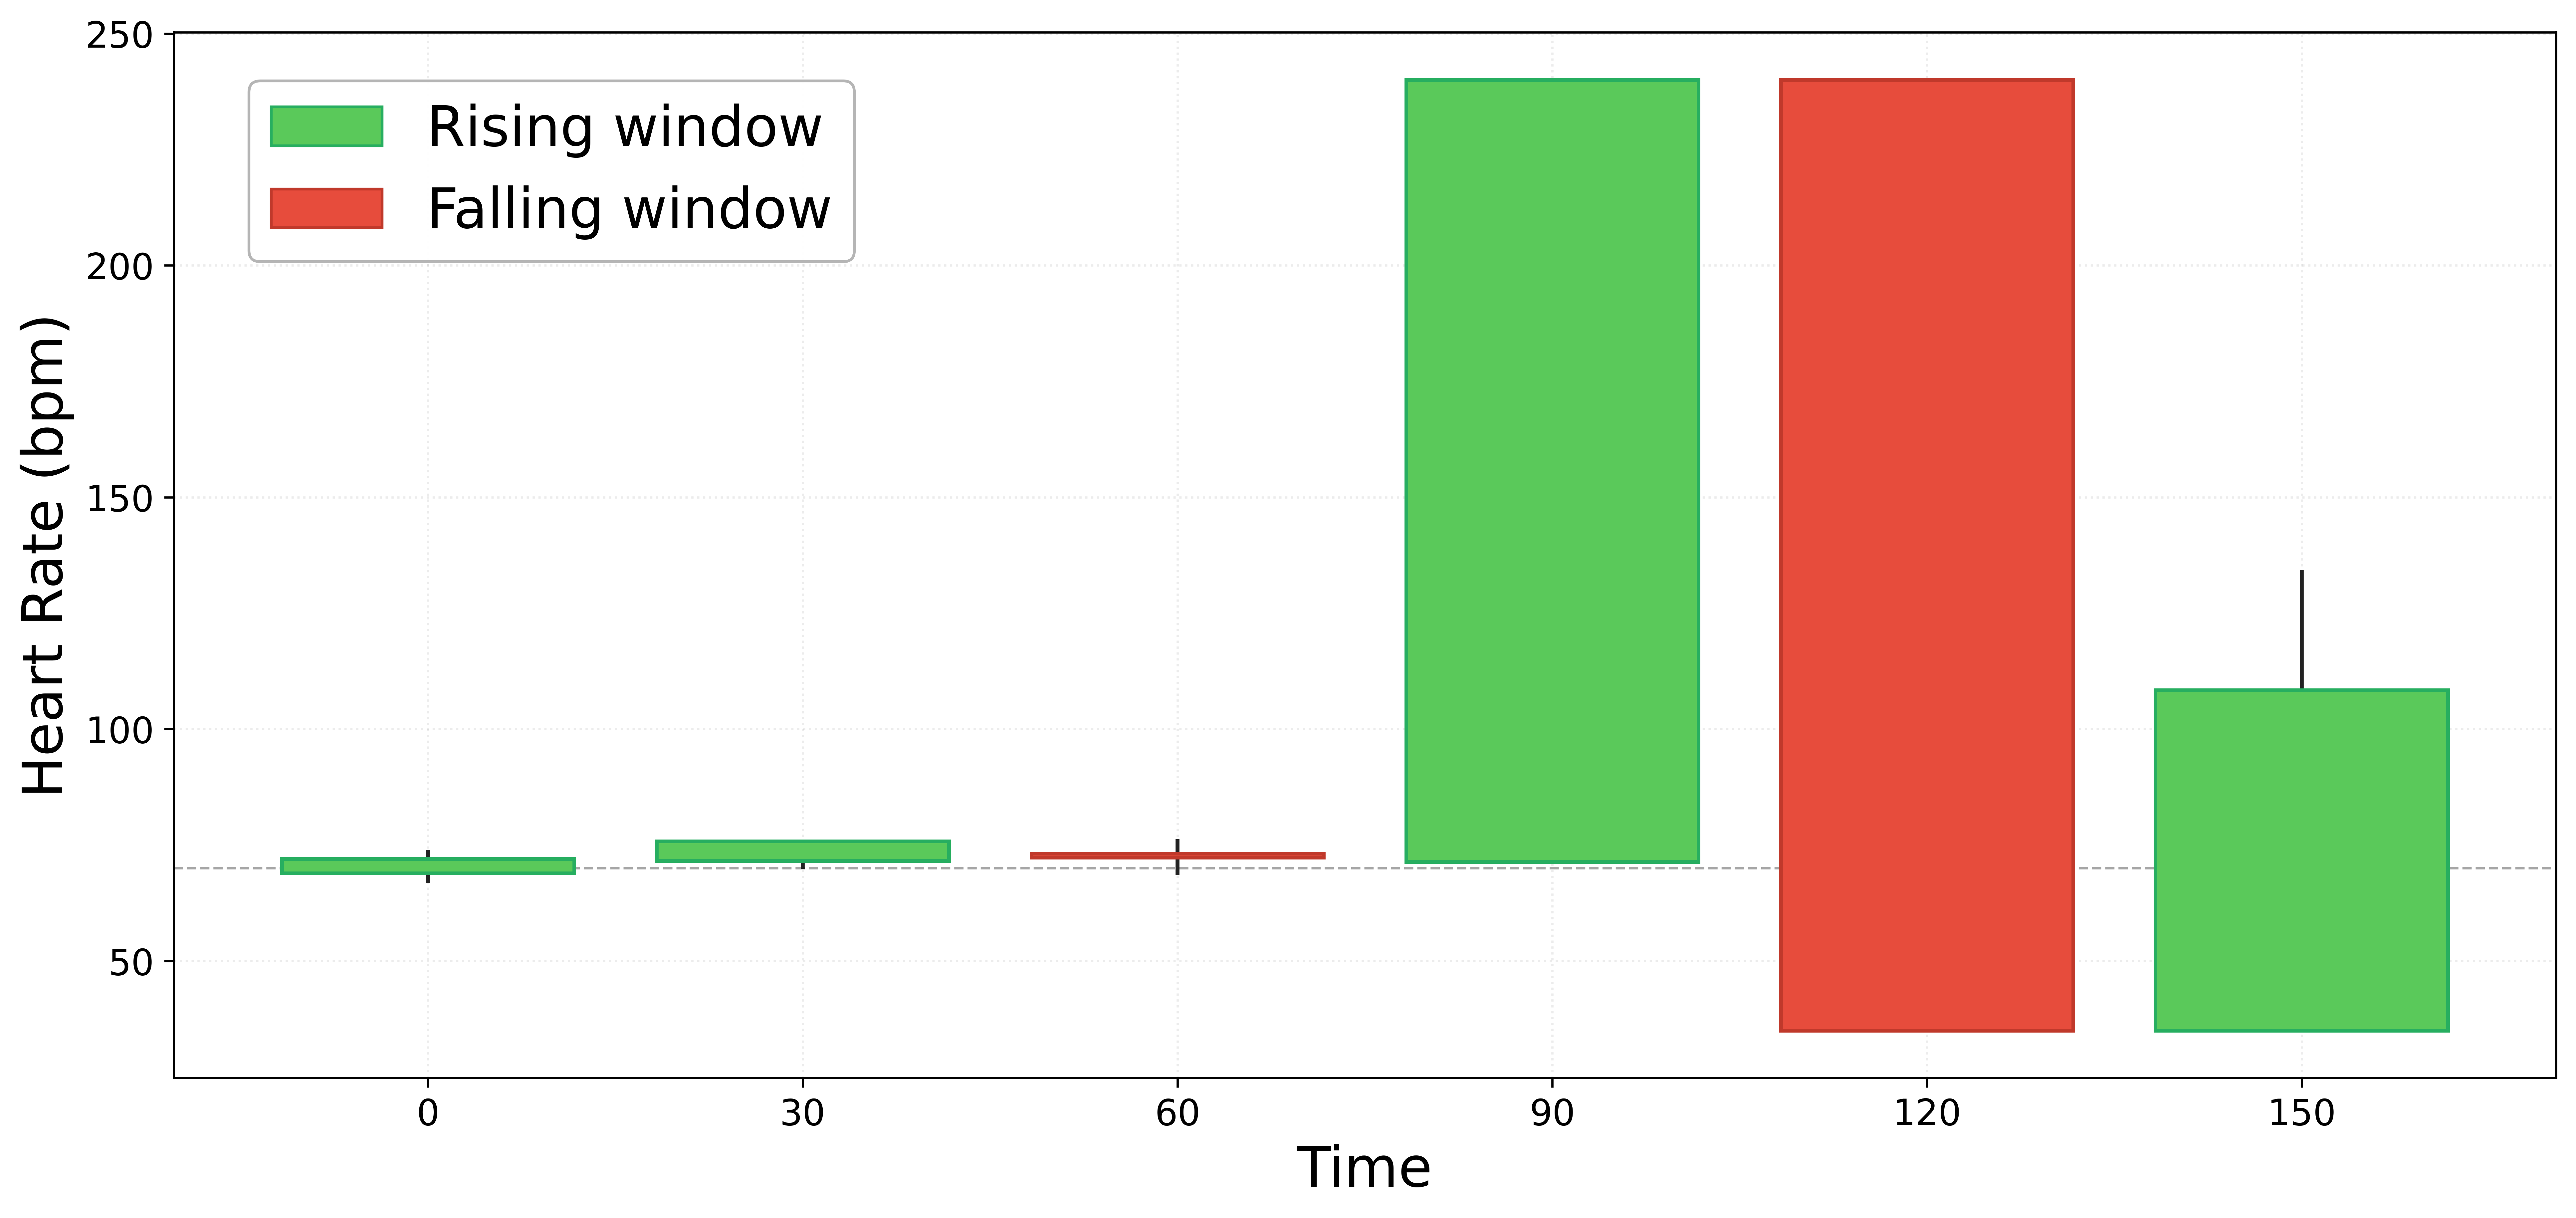

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

np.random.seed(42)

# ────────────────────────────────────────────────
# Generate realistic heart-rate-like signal with acute cardiac event
# ────────────────────────────────────────────────
def heart_attack_scenario(n_points=180):
    t = np.arange(n_points)
    
    base = 68 + 6 * np.sin(2 * np.pi * t / (n_points * 1.2)) + 0.4 * t / n_points
    noise = np.random.normal(0, 1.8, n_points)
    
    # Heart attack section
    onset  = 92
    peak   = 118
    
    rise = np.where((t >= onset) & (t < peak),
                    48 * np.exp(-(t - onset - 8)**2 / (2 * 9**2)), 0)
    
    high_plateau = np.where((t >= peak) & (t < peak + 28),
                            165 + 14 * np.sin(12 * t) + np.random.normal(0, 5.5, n_points), 0)
    
    drop_start = peak + 28
    drop = np.where((t >= drop_start) & (t < drop_start + 18),
                    -110 * np.exp(-(t - drop_start - 4)**2 / (2 * 7**2)), 0)
    
    post_low_osc = np.where(t >= drop_start + 18,
                            55 + 18 * np.sin(0.9 * (t - drop_start)) * np.exp(-(t - drop_start - 25)/40),
                            0)
    
    signal = base + noise + rise + high_plateau + drop + post_low_osc
    signal = np.clip(signal, 35, 240)
    return signal


# ────────────────────────────────────────────────
def build_candles(signal, window=30):
    opens, highs, lows, closes = [], [], [], []
    for i in range(0, len(signal), window):
        chunk = signal[i:i + window]
        if len(chunk) < 2:
            break
        opens.append(chunk[0])
        highs.append(np.max(chunk))
        lows.append(np.min(chunk))
        closes.append(chunk[-1])
    return opens, highs, lows, closes


# ────────────────────────────────────────────────
def plot_candles_heart_attack(opens, highs, lows, closes, window_size=30):
    fig, ax = plt.subplots(figsize=(13, 6.2), dpi=600)
    
    x = np.arange(len(opens)) * window_size   # time in seconds

    opens  = np.array(opens)
    highs  = np.array(highs)
    lows   = np.array(lows)
    closes = np.array(closes)

    # ─── Candles ─────────────────────────────────────
    for i in range(len(opens)):
        up = closes[i] >= opens[i]
        color      = "#5ac95a" if up else "#e74c3c"
        edgecolor  = "#27ae60" if up else "#c0392b"
        center     = x[i]
        width      = window_size * 0.78

        ax.vlines(center, lows[i], highs[i], color="#222", lw=1.4, zorder=3)
        bottom = min(opens[i], closes[i])
        height = abs(closes[i] - opens[i])
        ax.add_patch(plt.Rectangle(
            (center - width/2, bottom), width, height,
            facecolor=color, edgecolor=edgecolor, lw=1.3, zorder=4
        ))

    # ─── Reference lines & style ─────────────────────
    ax.axhline(70, color="0.5", ls="--", lw=0.9, alpha=0.7, zorder=1,
               label="Typical resting HR (~70 bpm)")

    ax.set_xlabel("Time (seconds)", fontsize=20)
    ax.set_ylabel("Heart Rate (bpm)", fontsize=20)

    ax.set_xticks(x)
    ax.set_xticklabels([f"{int(v)}" for v in x], fontsize=20)

    ax.grid(True, alpha=0.18, ls=":", color="0.6")
    ax.tick_params(labelsize=13)

    leg = [
        Patch(facecolor="#5ac95a", edgecolor="#27ae60", label="Rising window"),
        Patch(facecolor="#e74c3c", edgecolor="#c0392b", label="Falling window"),
    ]
    ax.legend(handles=leg, loc="upper left", fontsize=20,
              framealpha=0.97, edgecolor="0.7", bbox_to_anchor=(0.02, 0.98))

    plt.tight_layout()
    
    # Optional: save high-res versions
    # plt.savefig("heart_attack_candles_30s_clean.png", dpi=600, bbox_inches="tight")
    # plt.savefig("heart_attack_candles_30s_clean.pdf", bbox_inches="tight")  # vector — best for print/zoom
    
    plt.show()


# ────────────────────────────────────────────────
if __name__ == "__main__":
    signal = heart_attack_scenario(180)
    opens, highs, lows, closes = build_candles(signal, window=30)
    plot_candles_heart_attack(opens, highs, lows, closes, window_size=30)

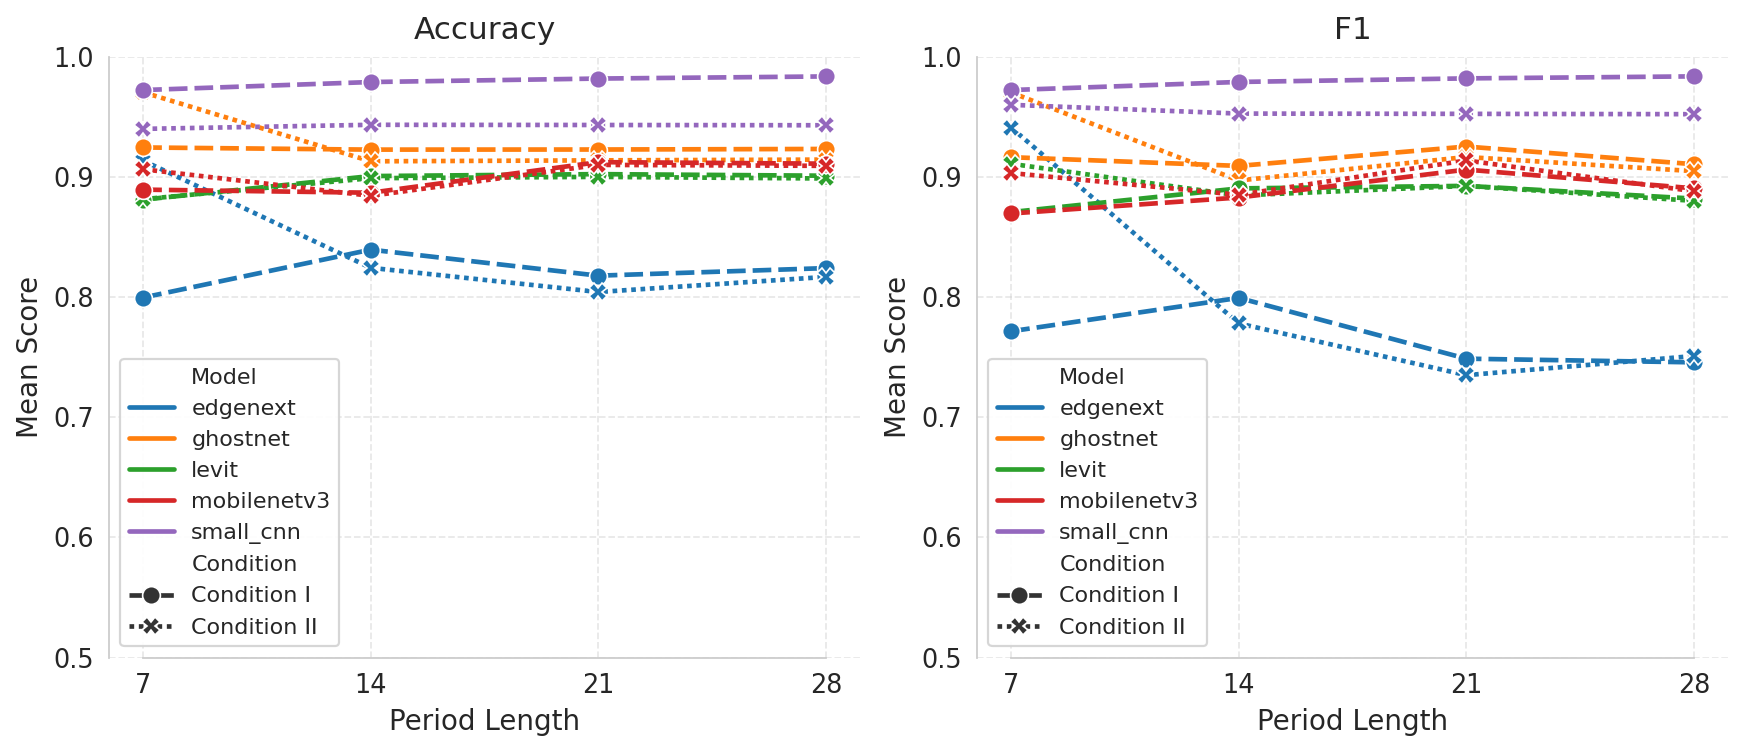

Saved: performance_vs_period_ExpA.png


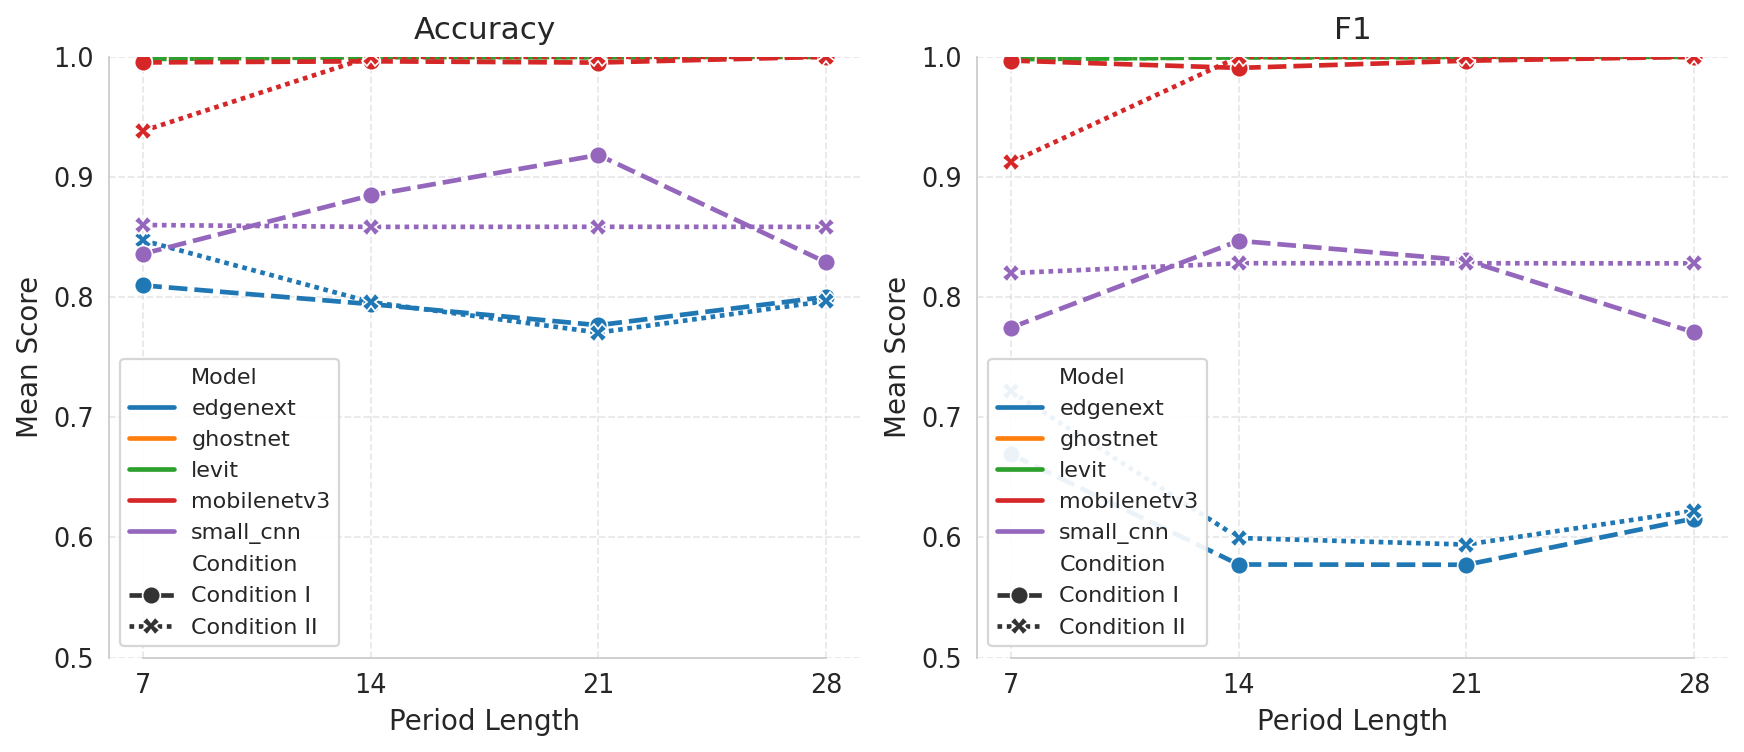

Saved: performance_vs_period_ExpB.png


In [5]:
# =============================================================================
# Plot: Model Performance across Period Lengths (7, 14, 21, 28 days)
# ── One figure per Labeling (Exp A / Exp B)
# ── Both Condition I and II shown in same plot using line style
# ── Subplots: Accuracy | F1
# ── NO confidence interval bands
# ── Y-axis forced to show up to 1.0 (so Exp A small_cnn at 0.94/0.96 is visible properly)
# =============================================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ── Style ────────────────────────────────────────────────────────────────────
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.family':      'DejaVu Sans',
    'figure.dpi':       160,
    'axes.titlesize':   14,
    'axes.labelsize':   13,
    'xtick.labelsize':  11.5,
    'ytick.labelsize':  11.5,
    'legend.fontsize':  10.5,
})

# ── Load & prepare data ──────────────────────────────────────────────────────
base_path = Path("/home/nckh2/qa/delete")
files = list(base_path.rglob("*_exp*_results.csv"))

dfs = []
for f in files:
    df_temp = pd.read_csv(f)
    labeling = "Exp A" if "ExpA" in str(f) else "Exp B"
    cond     = "Condition I" if "exp1" in f.name.lower() else "Condition II"
    df_temp['Labeling']   = labeling
    df_temp['Condition']  = cond
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

# ── Hardcode missing small_cnn values (constant across all periods) ──────────
small_cnn_values = {
    "Exp A": {"Accuracy": 0.94, "F1": 0.96},
    "Exp B": {"Accuracy": 0.86, "F1": 0.82},
}

missing_rows = []
for labeling, metrics in small_cnn_values.items():
    for days in [7, 14, 21, 28]:
        for cond in ["Condition I", "Condition II"]:
            missing_rows.append({
                "Model":       "small_cnn",
                "Period":      f"{days}_days",           # match your naming style
                "Accuracy":    metrics["Accuracy"],
                "F1":          metrics["F1"],
                "Labeling":    labeling,
                "Condition":   cond,
                "Period_days": float(days),              # for numeric x-axis
            })

if missing_rows:
    df = pd.concat([df, pd.DataFrame(missing_rows)], ignore_index=True)

# ── Clean & filter periods ──────────────────────────────────────────────────
df['Period_days'] = df['Period'].str.extract(r'(\d+)').astype(float)
df = df[df['Period_days'].isin([7, 14, 21, 28])]

# ── Model order & colors ─────────────────────────────────────────────────────
# Alphabetical order → existing models keep original colors
model_order = sorted(df['Model'].unique())

palette = dict(zip(
    model_order,
    sns.color_palette('tab10', len(model_order))
))

# Optional: make small_cnn stand out (uncomment if desired)
# palette['small_cnn'] = '#d62728'  # red
# palette['small_cnn'] = '#9467bd'  # purple
# palette['small_cnn'] = '#2ca02c'  # forest green

# ── Plot: one figure per Labeling ────────────────────────────────────────────
for labeling in sorted(df['Labeling'].unique()):
    subset = df[df['Labeling'] == labeling]
    if subset.empty:
        continue

    fig, axes = plt.subplots(1, 2, figsize=(11, 4.8), sharey=False)

    for i, metric in enumerate(['Accuracy', 'F1']):
        ax = axes[i]

        sns.lineplot(
            data=subset,
            x='Period_days',
            y=metric,
            hue='Model',
            hue_order=model_order,
            style='Condition',
            markers=True,
            markersize=8,
            linewidth=2.1,
            palette=palette,
            dashes=[(4, 1.5), (1, 1)],           # solid = Cond I, dashed = Cond II
            errorbar=None,                       # no confidence bands
            ax=ax
        )

        # ── Force y-axis to show up to 1.0 (fixes Exp A visibility) ──────────
        ax.set_ylim(0.50, 1.00)
        ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

        ax.set_title(metric, pad=8)
        ax.set_xlabel("Period Length", fontsize=12.5)
        ax.set_ylabel("Mean Score", fontsize=12.5)
        ax.set_xticks([7, 14, 21, 28])
        ax.grid(True, linestyle='--', alpha=0.45)
        sns.despine(ax=ax, trim=True)

        # Legend
        ax.legend(
            loc='lower left',
            fontsize=10,
            title_fontsize=11,
            frameon=True,
            framealpha=0.92,
            edgecolor='lightgray'
        )

    plt.tight_layout()

    filename = f"performance_vs_period_{labeling.replace(' ','')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Saved: {filename}")